# Book 9b: Feature Selection Pipeline (Med-Averse Variant)
 
## Hybrid Two-Phase Approach with Medication Feature Deprioritization
 
This is a variant of V2_Book9 that applies a **tiebreaker penalty** to medication features
(`out_med_*` and `inp_med_*` prefixes) during both Phase 1 and Phase 2 culling.
 
**Motivation:** Medication data is the hardest to replicate on the parallel platform.
When two features are nearly equal in importance, this variant prefers to keep the
non-medication feature and drop the medication one.
 
**Changes from original Book 9:**
- Phase 1: Within each cluster, when features have SHAP_Ratios within 5% of each other,
  non-medication features rank above medication features (tiebreaker)
- Phase 2: Medication features get a small penalty in the removal priority score,
  so they are removed first when tied with non-med features
 
| Phase | Method | Features | Purpose |
|-------|--------|----------|--------|
| **Phase 1** | Cluster-Based Reduction | 167 → ~143 | Remove redundant features (med-averse tiebreak) |
| **Phase 2** | Iterative SHAP Winnowing | ~143 → ~25 | Fine-tune with med-averse removal priority |
| **Phase 3** | CV Stability Analysis | ~25 → final | Validate selection across 5 folds |
 
## Key Features
- **Med-averse tiebreaking** - when features are nearly equal, prefer non-medication features
- **Dynamic clustering threshold** via silhouette score (not fixed 0.7)
- **2:1 SHAP weighting** for positive cases (model handles imbalance via scale_pos_weight)
- **Clinical must-keep features** - preserve interpretable CRC signals regardless of ranking
- **5-fold CV stability analysis** - identify features robust across different train/val splits
- **Granular checkpoints** - stop anytime and resume without starting over
 
## Checkpoint System
Checkpoints saved after each step using portable formats (JSON for models, Parquet for DataFrames).
Kill notebook anytime, re-run to resume. Backward compatible with legacy pickle checkpoints.

## Configuration

In [0]:
# ============================================================================
# CONFIGURATION - Modify these as needed
# ============================================================================

# Resume behavior: Set to True to check for and resume from checkpoints
# Set to False to start fresh (will prompt to confirm clearing checkpoints)
AUTO_RESUME = True

# =============================================================================
# PHASE 2 REMOVAL CRITERIA (from original CRC_ITER1_MODEL-PREVALENCE.py)
# =============================================================================
# Feature must meet AT LEAST 2 of 3 criteria to be eligible for removal:
#   1. Near-zero SHAP importance (< ZERO_SHAP_THRESHOLD)
#   2. Negative-biased ratio (< NEG_BIAS_RATIO_THRESHOLD)
#   3. Bottom percentile by SHAP (< BOTTOM_PERCENTILE)
# =============================================================================
ZERO_SHAP_THRESHOLD = 0.0005     # Near-zero importance threshold (raised from 0.0002)
NEG_BIAS_RATIO_THRESHOLD = 0.25  # Negative-bias ratio threshold (raised from 0.15)
BOTTOM_PERCENTILE = 12           # Bottom percentile threshold (raised from 8)

# Iteration limits - gradual reduction to prevent model destabilization
MAX_REMOVALS_EARLY = 10          # Cap for iterations 1-5 (was 30, caused crashes)
MAX_REMOVALS_LATE = 5            # Cap for iterations 6+ (finer control)
LATE_PHASE_ITERATION = 5         # Switch to finer control after this iteration
MIN_FEATURES_THRESHOLD = 25      # Target final feature count

# Phase 1 validation gate
PHASE1_MAX_VAL_DROP = 0.10       # Allow up to 10% drop in Phase 1

# Visualization thresholds (reference lines in plots, not used for stopping)
MAX_VAL_AUPRC_DROP = 0.05        # 5% drop reference line
MAX_GAP_INCREASE = 0.02          # Gap increase reference line

# Clustering configuration
# Use silhouette optimization, but constrain to reasonable range
# Target: ~40-60 clusters for ~170 features (allows meaningful cluster reduction)
MIN_CLUSTERING_THRESHOLD = 0.60  # Floor - prevents too many tiny clusters
MAX_CLUSTERING_THRESHOLD = 0.85  # Ceiling - prevents too few giant clusters
TARGET_CLUSTER_RANGE = (40, 70)  # Prefer thresholds giving this many clusters

# Threshold search range
THRESHOLD_MIN = 0.50
THRESHOLD_MAX = 0.90
THRESHOLD_STEP = 0.05

# Random seed for reproducibility
RANDOM_SEED = 217

# Output directories
CHECKPOINT_DIR = "checkpoints"
OUTPUT_DIR = "feature_selection_outputs"

# =============================================================================
# CLINICAL MUST-KEEP FEATURES
# =============================================================================
# These features are preserved regardless of their statistical ranking.
# They represent clinically important or interpretable signals that should
# always be available in the final model for clinical decision-making.
#
# To add a feature: Include the exact column name as it appears in the data.
# To disable: Set CLINICAL_MUST_KEEP_FEATURES = [] (empty list)
# =============================================================================
CLINICAL_MUST_KEEP_FEATURES = [
    # Weight loss indicators - cardinal sign of CRC
    'HAS_RAPID_WEIGHT_LOSS',
    'MAX_WEIGHT_LOSS_PCT_60D',
    'WEIGHT_LOSS_FLAG_6M',

    # GI bleeding - high-specificity CRC symptom
    'HAS_GI_BLEEDING',
    'HAS_RECTAL_BLEEDING',

    # Anemia - common CRC presentation
    'HAS_IRON_DEFICIENCY_ANEMIA',
    'HEMOGLOBIN_LATEST',

    # Age - fundamental risk factor
    'AGE',

    # Change in bowel habits - classic CRC symptom
    'HAS_BOWEL_HABIT_CHANGE',
]

# Number of CV folds for feature selection stability
N_CV_FOLDS = 5
CV_FEATURE_THRESHOLD = 0.60  # Keep features appearing in >= 60% of folds (3/5)


# =============================================================================
# MEDICATION FEATURE DEPRIORITIZATION (Med-Averse Variant)
# =============================================================================
# Medication features (from Books 5.1 and 5.2) are harder to obtain on the
# parallel platform. When features are nearly equal in importance, we prefer
# to keep non-medication features.
#
# MED_FEATURE_PREFIXES: Prefixes that identify medication features
# MED_TIEBREAK_BAND: In Phase 1, features within this % of each other's
#   SHAP_Ratio are considered "tied" and the tiebreaker applies
# MED_PRIORITY_PENALTY: In Phase 2, subtracted from med feature priority_score
#   (lower score = removed first), only matters for ties
# =============================================================================
MED_FEATURE_PREFIXES = ('out_med_', 'inp_med_')
MED_TIEBREAK_BAND = 0.05          # 5% band for Phase 1 tiebreaking
MED_PRIORITY_PENALTY = 0.001      # Small penalty for Phase 2 priority score

def is_medication_feature(feature_name):
    """Check if a feature is a medication feature based on its prefix."""
    return feature_name.startswith(MED_FEATURE_PREFIXES)

print("="*70)
print("CONFIGURATION (Original Methodology)")
print("="*70)
print(f"AUTO_RESUME: {AUTO_RESUME}")
print(f"\nRemoval Criteria (must meet 3+ of 5):")
print(f"  ZERO_SHAP_THRESHOLD: {ZERO_SHAP_THRESHOLD}")
print(f"  NEG_BIAS_RATIO_THRESHOLD: {NEG_BIAS_RATIO_THRESHOLD}")
print(f"  BOTTOM_PERCENTILE: {BOTTOM_PERCENTILE}%")
print(f"\nIteration Limits:")
print(f"  MAX_REMOVALS_EARLY (iter 1-{LATE_PHASE_ITERATION}): {MAX_REMOVALS_EARLY}")
print(f"  MAX_REMOVALS_LATE (iter {LATE_PHASE_ITERATION+1}+): {MAX_REMOVALS_LATE}")
print(f"  MIN_FEATURES_THRESHOLD: {MIN_FEATURES_THRESHOLD}")
print(f"\nClustering:")
print(f"  MIN_CLUSTERING_THRESHOLD: {MIN_CLUSTERING_THRESHOLD}")
print(f"  MAX_CLUSTERING_THRESHOLD: {MAX_CLUSTERING_THRESHOLD}")
print(f"  TARGET_CLUSTER_RANGE: {TARGET_CLUSTER_RANGE}")
print(f"\nOther:")
print(f"  RANDOM_SEED: {RANDOM_SEED}")
print(f"  CLINICAL_MUST_KEEP_FEATURES: {len(CLINICAL_MUST_KEEP_FEATURES)} features")
print(f"  MED_FEATURE_PREFIXES: {MED_FEATURE_PREFIXES}")
print(f"  MED_TIEBREAK_BAND: {MED_TIEBREAK_BAND*100:.0f}%")
print(f"  MED_PRIORITY_PENALTY: {MED_PRIORITY_PENALTY}")
print("="*70)

CONFIGURATION (Original Methodology)
AUTO_RESUME: True

Removal Criteria (must meet 3+ of 5):
  ZERO_SHAP_THRESHOLD: 0.0005
  NEG_BIAS_RATIO_THRESHOLD: 0.25
  BOTTOM_PERCENTILE: 12%

Iteration Limits:
  MAX_REMOVALS_EARLY (iter 1-5): 10
  MAX_REMOVALS_LATE (iter 6+): 5
  MIN_FEATURES_THRESHOLD: 25

Clustering:
  MIN_CLUSTERING_THRESHOLD: 0.6
  MAX_CLUSTERING_THRESHOLD: 0.85
  TARGET_CLUSTER_RANGE: (40, 70)

Other:
  RANDOM_SEED: 217
  CLINICAL_MUST_KEEP_FEATURES: 9 features
  MED_FEATURE_PREFIXES: ('out_med_', 'inp_med_')
  MED_TIEBREAK_BAND: 5%
  MED_PRIORITY_PENALTY: 0.001


## Imports and Environment Setup

In [0]:
import os
import pickle
import json
import time
from datetime import datetime
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.spatial.distance import squareform
from sklearn.metrics import (
    silhouette_score, average_precision_score, roc_auc_score, brier_score_loss
)

from xgboost import XGBClassifier
import shap

from pyspark.sql import SparkSession
from pyspark.sql import functions as F

# Verify Parquet support (required for checkpoint system)
try:
    import pyarrow
    print(f"PyArrow version: {pyarrow.__version__}")
except ImportError:
    raise ImportError(
        "PyArrow is required for Parquet checkpoint support. "
        "Install with: pip install pyarrow"
    )

# Initialize Spark
spark = SparkSession.builder.getOrCreate()
spark.conf.set("spark.sql.session.timeZone", "America/Chicago")

# Get catalog from environment
trgt_cat = os.environ.get('trgt_cat', 'dev')

# Track overall pipeline start time
PIPELINE_START_TIME = time.time()

print("="*70)
print("ENVIRONMENT INITIALIZED")
print("="*70)
print(f"Timestamp: {datetime.now()}")
print(f"Spark version: {spark.version}")
print(f"Target catalog: {trgt_cat}")
print("="*70)

PyArrow version: 14.0.1
ENVIRONMENT INITIALIZED
Timestamp: 2026-02-05 18:25:25.804476
Spark version: 3.5.0
Target catalog: dev


In [0]:
# ============================================================================
# CONFIGURATION - Modify these as needed
# ============================================================================

# Resume behavior: Set to True to check for and resume from checkpoints
# Set to False to start fresh (will prompt to confirm clearing checkpoints)
AUTO_RESUME = True

# =============================================================================
# PHASE 2 REMOVAL CRITERIA (from original CRC_ITER1_MODEL-PREVALENCE.py)
# =============================================================================
# Feature must meet AT LEAST 2 of 3 criteria to be eligible for removal:
#   1. Near-zero SHAP importance (< ZERO_SHAP_THRESHOLD)
#   2. Negative-biased ratio (< NEG_BIAS_RATIO_THRESHOLD)
#   3. Bottom percentile by SHAP (< BOTTOM_PERCENTILE)
# =============================================================================
ZERO_SHAP_THRESHOLD = 0.0005     # Near-zero importance threshold (raised from 0.0002)
NEG_BIAS_RATIO_THRESHOLD = 0.25  # Negative-bias ratio threshold (raised from 0.15)
BOTTOM_PERCENTILE = 12           # Bottom percentile threshold (raised from 8)

# Iteration limits - gradual reduction to prevent model destabilization
MAX_REMOVALS_EARLY = 10          # Cap for iterations 1-5 (was 30, caused crashes)
MAX_REMOVALS_LATE = 5            # Cap for iterations 6+ (finer control)
LATE_PHASE_ITERATION = 5         # Switch to finer control after this iteration
MIN_FEATURES_THRESHOLD = 25      # Target final feature count

# Phase 1 validation gate
PHASE1_MAX_VAL_DROP = 0.10       # Allow up to 10% drop in Phase 1

# Visualization thresholds (reference lines in plots, not used for stopping)
MAX_VAL_AUPRC_DROP = 0.05        # 5% drop reference line
MAX_GAP_INCREASE = 0.02          # Gap increase reference line

# Clustering configuration
# Use silhouette optimization, but constrain to reasonable range
# Target: ~40-60 clusters for ~170 features (allows meaningful cluster reduction)
MIN_CLUSTERING_THRESHOLD = 0.60  # Floor - prevents too many tiny clusters
MAX_CLUSTERING_THRESHOLD = 0.85  # Ceiling - prevents too few giant clusters
TARGET_CLUSTER_RANGE = (40, 70)  # Prefer thresholds giving this many clusters

# Threshold search range
THRESHOLD_MIN = 0.50
THRESHOLD_MAX = 0.90
THRESHOLD_STEP = 0.05

# Random seed for reproducibility
RANDOM_SEED = 217

# Output directories
CHECKPOINT_DIR = "checkpoints"
OUTPUT_DIR = "feature_selection_outputs"

# =============================================================================
# CLINICAL MUST-KEEP FEATURES
# =============================================================================
# These features are preserved regardless of their statistical ranking.
# They represent clinically important or interpretable signals that should
# always be available in the final model for clinical decision-making.
#
# To add a feature: Include the exact column name as it appears in the data.
# To disable: Set CLINICAL_MUST_KEEP_FEATURES = [] (empty list)
# =============================================================================
CLINICAL_MUST_KEEP_FEATURES = [
    # Weight loss indicators - cardinal sign of CRC
    'HAS_RAPID_WEIGHT_LOSS',
    'MAX_WEIGHT_LOSS_PCT_60D',
    'WEIGHT_LOSS_FLAG_6M',

    # GI bleeding - high-specificity CRC symptom
    'HAS_GI_BLEEDING',
    'HAS_RECTAL_BLEEDING',

    # Anemia - common CRC presentation
    'HAS_IRON_DEFICIENCY_ANEMIA',
    'HEMOGLOBIN_LATEST',

    # Age - fundamental risk factor
    'AGE',

    # Change in bowel habits - classic CRC symptom
    'HAS_BOWEL_HABIT_CHANGE',
]

# Number of CV folds for feature selection stability
N_CV_FOLDS = 5
CV_FEATURE_THRESHOLD = 0.6  # Keep features appearing in >= 60% of folds (3/5)


# =============================================================================
# MEDICATION FEATURE DEPRIORITIZATION (Med-Averse Variant)
# =============================================================================
# Medication features (from Books 5.1 and 5.2) are harder to obtain on the
# parallel platform. When features are nearly equal in importance, we prefer
# to keep non-medication features.
#
# MED_FEATURE_PREFIXES: Prefixes that identify medication features
# MED_TIEBREAK_BAND: In Phase 1, features within this % of each other's
#   SHAP_Ratio are considered "tied" and the tiebreaker applies
# MED_PRIORITY_PENALTY: In Phase 2, subtracted from med feature priority_score
#   (lower score = removed first), only matters for ties
# =============================================================================
MED_FEATURE_PREFIXES = ('out_med_', 'inp_med_')
MED_TIEBREAK_BAND = 0.05          # 5% band for Phase 1 tiebreaking
MED_PRIORITY_PENALTY = 0.001      # Small penalty for Phase 2 priority score

def is_medication_feature(feature_name):
    """Check if a feature is a medication feature based on its prefix."""
    return feature_name.startswith(MED_FEATURE_PREFIXES)

print("="*70)
print("CONFIGURATION (Original Methodology)")
print("="*70)
print(f"AUTO_RESUME: {AUTO_RESUME}")
print(f"\nRemoval Criteria (must meet 3+ of 5):")
print(f"  ZERO_SHAP_THRESHOLD: {ZERO_SHAP_THRESHOLD}")
print(f"  NEG_BIAS_RATIO_THRESHOLD: {NEG_BIAS_RATIO_THRESHOLD}")
print(f"  BOTTOM_PERCENTILE: {BOTTOM_PERCENTILE}%")
print(f"\nIteration Limits:")
print(f"  MAX_REMOVALS_EARLY (iter 1-{LATE_PHASE_ITERATION}): {MAX_REMOVALS_EARLY}")
print(f"  MAX_REMOVALS_LATE (iter {LATE_PHASE_ITERATION+1}+): {MAX_REMOVALS_LATE}")
print(f"  MIN_FEATURES_THRESHOLD: {MIN_FEATURES_THRESHOLD}")
print(f"\nClustering:")
print(f"  MIN_CLUSTERING_THRESHOLD: {MIN_CLUSTERING_THRESHOLD}")
print(f"  MAX_CLUSTERING_THRESHOLD: {MAX_CLUSTERING_THRESHOLD}")
print(f"  TARGET_CLUSTER_RANGE: {TARGET_CLUSTER_RANGE}")
print(f"\nOther:")
print(f"  RANDOM_SEED: {RANDOM_SEED}")
print(f"  CLINICAL_MUST_KEEP_FEATURES: {len(CLINICAL_MUST_KEEP_FEATURES)} features")
print(f"  MED_FEATURE_PREFIXES: {MED_FEATURE_PREFIXES}")
print(f"  MED_TIEBREAK_BAND: {MED_TIEBREAK_BAND*100:.0f}%")
print(f"  MED_PRIORITY_PENALTY: {MED_PRIORITY_PENALTY}")
print("="*70)

CONFIGURATION (Original Methodology)
AUTO_RESUME: True

Removal Criteria (must meet 3+ of 5):
  ZERO_SHAP_THRESHOLD: 0.0005
  NEG_BIAS_RATIO_THRESHOLD: 0.25
  BOTTOM_PERCENTILE: 12%

Iteration Limits:
  MAX_REMOVALS_EARLY (iter 1-5): 10
  MAX_REMOVALS_LATE (iter 6+): 5
  MIN_FEATURES_THRESHOLD: 25

Clustering:
  MIN_CLUSTERING_THRESHOLD: 0.6
  MAX_CLUSTERING_THRESHOLD: 0.85
  TARGET_CLUSTER_RANGE: (40, 70)

Other:
  RANDOM_SEED: 217
  CLINICAL_MUST_KEEP_FEATURES: 9 features
  MED_FEATURE_PREFIXES: ('out_med_', 'inp_med_')
  MED_TIEBREAK_BAND: 5%
  MED_PRIORITY_PENALTY: 0.001


## Checkpoint Management Functions
 
Checkpoints use portable, version-stable formats:
- **XGBoost models**: JSON format via `model.save_model()` (portable across XGBoost versions)
- **DataFrames**: Parquet format (efficient, schema-preserving)
- **NumPy arrays**: `.npy` format
- **Simple types**: JSON format
- **Complex objects**: Pickle fallback (scipy linkage matrices, etc.)
 
Each checkpoint is stored as a directory with typed files + metadata.
Legacy pickle checkpoints (`.pkl` files) are still supported for backward compatibility.

In [0]:
def ensure_directories():
    """Create checkpoint and output directories if they don't exist."""
    os.makedirs(CHECKPOINT_DIR, exist_ok=True)
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    print(f"✓ Directories verified: {CHECKPOINT_DIR}/, {OUTPUT_DIR}/")

def get_checkpoint_dir(name):
    """Get directory path for a checkpoint (each checkpoint is a directory)."""
    return os.path.join(CHECKPOINT_DIR, name)

def save_checkpoint(name, data):
    """
    Save a checkpoint with format-appropriate storage:
    - XGBoost models: JSON format (portable across versions)
    - DataFrames: Parquet format (efficient, portable)
    - Other data: JSON for simple types, pickle for complex types
    """
    checkpoint_dir = get_checkpoint_dir(name)
    os.makedirs(checkpoint_dir, exist_ok=True)

    metadata = {'keys': []}

    for key, value in data.items():
        metadata['keys'].append(key)

        if isinstance(value, XGBClassifier):
            # Save XGBoost model as JSON
            model_path = os.path.join(checkpoint_dir, f"{key}.json")
            value.save_model(model_path)

        elif isinstance(value, pd.DataFrame):
            # Save DataFrame as Parquet
            parquet_path = os.path.join(checkpoint_dir, f"{key}.parquet")
            value.to_parquet(parquet_path, index=False)

        elif isinstance(value, np.ndarray):
            # Save numpy arrays as .npy
            npy_path = os.path.join(checkpoint_dir, f"{key}.npy")
            np.save(npy_path, value)

        elif isinstance(value, (list, dict, str, int, float, bool, type(None))):
            # Save simple types as JSON
            json_path = os.path.join(checkpoint_dir, f"{key}.json")
            with open(json_path, 'w') as f:
                json.dump(value, f, indent=2, default=str)

        else:
            # Fallback to pickle for complex types (scipy linkage, etc.)
            pkl_path = os.path.join(checkpoint_dir, f"{key}.pkl")
            with open(pkl_path, 'wb') as f:
                pickle.dump(value, f)

    # Save metadata
    with open(os.path.join(checkpoint_dir, "_metadata.json"), 'w') as f:
        json.dump(metadata, f)

    print(f"✓ CHECKPOINT SAVED: {name}")

def load_checkpoint(name):
    """Load a checkpoint by name. Returns None if not found."""
    checkpoint_dir = get_checkpoint_dir(name)

    # Check for new format (directory-based)
    if os.path.isdir(checkpoint_dir):
        metadata_path = os.path.join(checkpoint_dir, "_metadata.json")
        if not os.path.exists(metadata_path):
            return None

        with open(metadata_path, 'r') as f:
            metadata = json.load(f)

        data = {}
        for key in metadata['keys']:
            # Try each format in order
            json_path = os.path.join(checkpoint_dir, f"{key}.json")
            parquet_path = os.path.join(checkpoint_dir, f"{key}.parquet")
            npy_path = os.path.join(checkpoint_dir, f"{key}.npy")
            pkl_path = os.path.join(checkpoint_dir, f"{key}.pkl")

            if key == 'model' and os.path.exists(json_path):
                # Load XGBoost model
                model = XGBClassifier()
                model.load_model(json_path)
                data[key] = model
            elif os.path.exists(parquet_path):
                # Load DataFrame
                data[key] = pd.read_parquet(parquet_path)
            elif os.path.exists(npy_path):
                # Load numpy array
                data[key] = np.load(npy_path)
            elif os.path.exists(json_path):
                # Load JSON
                with open(json_path, 'r') as f:
                    data[key] = json.load(f)
            elif os.path.exists(pkl_path):
                # Load pickle
                with open(pkl_path, 'rb') as f:
                    data[key] = pickle.load(f)

        print(f"✓ CHECKPOINT LOADED: {name}")
        return data

    # Fallback: check for legacy pickle format
    legacy_path = os.path.join(CHECKPOINT_DIR, f"{name}.pkl")
    if os.path.exists(legacy_path):
        print(f"⚠ Loading legacy pickle checkpoint: {name}")
        with open(legacy_path, 'rb') as f:
            data = pickle.load(f)
        print(f"✓ CHECKPOINT LOADED: {name} (legacy format)")
        return data

    return None

def checkpoint_exists(name):
    """Check if a checkpoint exists (new or legacy format)."""
    checkpoint_dir = get_checkpoint_dir(name)
    legacy_path = os.path.join(CHECKPOINT_DIR, f"{name}.pkl")
    return os.path.isdir(checkpoint_dir) or os.path.exists(legacy_path)

def list_checkpoints():
    """List all existing checkpoints (new and legacy formats)."""
    if not os.path.exists(CHECKPOINT_DIR):
        return []

    checkpoints = set()

    # New format: directories
    for item in os.listdir(CHECKPOINT_DIR):
        item_path = os.path.join(CHECKPOINT_DIR, item)
        if os.path.isdir(item_path) and os.path.exists(os.path.join(item_path, "_metadata.json")):
            checkpoints.add(item)

    # Legacy format: .pkl files
    for f in os.listdir(CHECKPOINT_DIR):
        if f.endswith('.pkl'):
            checkpoints.add(f.replace('.pkl', ''))

    return sorted(checkpoints)

def get_latest_checkpoint():
    """Determine the latest checkpoint and what step to resume from."""
    checkpoints = list_checkpoints()
    if not checkpoints:
        return None, "start"

    # Define checkpoint order
    checkpoint_order = [
        "step1_1_data",
        "step1_2_correlation",
        "step1_3_clusters",
        "step1_4_baseline_model",
        "step1_5_shap_phase1",
        "step1_6_cluster_representatives",
        "step1_7_phase1_complete"
    ]

    # Check Phase 1 checkpoints
    latest_phase1 = None
    for cp in checkpoint_order:
        if cp in checkpoints:
            latest_phase1 = cp

    # Check Phase 2 iteration checkpoints
    phase2_iters = [cp for cp in checkpoints if cp.startswith("step2_iter")]
    if phase2_iters:
        # Find highest iteration number
        iter_nums = []
        for cp in phase2_iters:
            try:
                # Extract iteration number from names like "step2_iter3_complete"
                parts = cp.split("_")
                iter_num = int(parts[1].replace("iter", ""))
                iter_nums.append((iter_num, cp))
            except:
                pass
        if iter_nums:
            max_iter = max(iter_nums, key=lambda x: x[0])
            return max_iter[1], f"phase2_iter{max_iter[0]}"

    if latest_phase1:
        return latest_phase1, latest_phase1

    return None, "start"

def clear_checkpoints():
    """Clear all checkpoints to start fresh (handles both new and legacy formats)."""
    import shutil

    if os.path.exists(CHECKPOINT_DIR):
        for item in os.listdir(CHECKPOINT_DIR):
            item_path = os.path.join(CHECKPOINT_DIR, item)
            if os.path.isdir(item_path):
                # New format: remove entire checkpoint directory
                shutil.rmtree(item_path)
            elif item.endswith('.pkl'):
                # Legacy format: remove pickle file
                os.remove(item_path)
        print("✓ All checkpoints cleared")

def display_checkpoint_status():
    """Display current checkpoint status."""
    checkpoints = list_checkpoints()
    latest, resume_point = get_latest_checkpoint()

    print("="*70)
    print("CHECKPOINT STATUS")
    print("="*70)

    if not checkpoints:
        print("No checkpoints found. Starting fresh.")
    else:
        print(f"Found {len(checkpoints)} checkpoint(s):")
        for cp in checkpoints:
            print(f"  - {cp}")
        print(f"\nLatest: {latest}")
        print(f"Resume point: {resume_point}")

    print("="*70)
    return latest, resume_point

# Initialize directories
ensure_directories()


✓ Directories verified: checkpoints/, feature_selection_outputs/


## Check for Existing Checkpoints and Resume Point

In [0]:
# Display checkpoint status and determine resume point
latest_checkpoint, resume_point = display_checkpoint_status()

# Determine whether to resume or start fresh
if latest_checkpoint and AUTO_RESUME:
    print(f"\n>>> AUTO_RESUME is ON. Resuming from: {resume_point}")
    START_FRESH = False
elif latest_checkpoint and not AUTO_RESUME:
    print(f"\n>>> Checkpoints exist but AUTO_RESUME is OFF.")
    print(">>> Set AUTO_RESUME = True to resume, or run clear_checkpoints() to start fresh.")
    START_FRESH = True
else:
    print("\n>>> No checkpoints found. Starting fresh.")
    START_FRESH = True

CHECKPOINT STATUS
Found 53 checkpoint(s):
  - step1_1_data
  - step1_1b_cv_folds
  - step1_2_correlation
  - step1_3_clusters
  - step1_4_baseline_model
  - step1_5_shap_phase1
  - step1_6_cluster_representatives
  - step1_7_phase1_complete
  - step2_iter10_complete
  - step2_iter10_model
  - step2_iter10_shap
  - step2_iter11_complete
  - step2_iter11_model
  - step2_iter11_shap
  - step2_iter12_complete
  - step2_iter12_model
  - step2_iter12_shap
  - step2_iter13_complete
  - step2_iter13_model
  - step2_iter13_shap
  - step2_iter14_complete
  - step2_iter14_model
  - step2_iter14_shap
  - step2_iter15_complete
  - step2_iter15_model
  - step2_iter15_shap
  - step2_iter1_complete
  - step2_iter1_model
  - step2_iter1_shap
  - step2_iter2_complete
  - step2_iter2_model
  - step2_iter2_shap
  - step2_iter3_complete
  - step2_iter3_model
  - step2_iter3_shap
  - step2_iter4_complete
  - step2_iter4_model
  - step2_iter4_shap
  - step2_iter5_complete
  - step2_iter5_model
  - step2_iter

## Utility Functions

In [0]:
def print_stage(stage_name, stage_num=None, total_stages=None):
    """Print a prominent stage marker with timestamp."""
    timestamp = datetime.now().strftime("%H:%M:%S")
    if stage_num and total_stages:
        header = f"[{timestamp}] STAGE {stage_num}/{total_stages}: {stage_name}"
    else:
        header = f"[{timestamp}] {stage_name}"
    print("\n" + "="*70)
    print(header)
    print("="*70)

def print_progress(message, indent=2):
    """Print a progress message with timestamp."""
    timestamp = datetime.now().strftime("%H:%M:%S")
    prefix = " " * indent
    print(f"{prefix}[{timestamp}] {message}")

def train_xgboost_model(X_train, y_train, X_val, y_val, feature_cols, scale_pos_weight):
    """
    Train an XGBoost model with conservative hyperparameters.
    Returns the trained model.
    """
    print_progress(f"Training XGBoost with {len(feature_cols)} features...")
    print_progress(f"Train: {len(y_train):,} obs, {int(y_train.sum()):,} events | Val: {len(y_val):,} obs, {int(y_val.sum()):,} events")

    # Conservative parameters from original CRC_ITER1_MODEL-PREVALENCE.py
    # These prevent overfitting on the highly imbalanced data
    params = {
        'max_depth': 3,              # Very shallow trees (original: 2)
        'min_child_weight': 50,      # Require substantial support
        'gamma': 2.0,                # High min loss reduction (original: 2.0)
        'subsample': 0.5,            # Low row sampling (original: 0.5)
        'colsample_bytree': 0.5,     # Low column sampling (original: 0.5)
        'colsample_bylevel': 0.5,    # Additional column regularization
        'reg_alpha': 5.0,            # L1 regularization (original: 5.0)
        'reg_lambda': 50.0,          # L2 regularization (original: 50.0)
        'learning_rate': 0.005,      # Very slow learning (original: 0.005)
        'n_estimators': 2000,
        'scale_pos_weight': scale_pos_weight,
        'objective': 'binary:logistic',
        'eval_metric': 'aucpr',
        'random_state': RANDOM_SEED,
        'early_stopping_rounds': 150  # More patience (original: 150)
    }

    start_time = time.time()
    model = XGBClassifier(**params)
    model.fit(
        X_train[feature_cols], y_train,
        eval_set=[(X_val[feature_cols], y_val)],
        verbose=False
    )
    elapsed = time.time() - start_time
    print_progress(f"Model trained in {elapsed:.1f}s (best iteration: {model.best_iteration})")

    return model

def evaluate_model(model, X, y, feature_cols, split_name=""):
    """
    Evaluate model and return metrics dictionary.
    """
    y_pred = model.predict_proba(X[feature_cols])[:, 1]

    auprc = average_precision_score(y, y_pred)
    auroc = roc_auc_score(y, y_pred)
    brier = brier_score_loss(y, y_pred)
    baseline_rate = y.mean()

    metrics = {
        'auprc': auprc,
        'auroc': auroc,
        'brier': brier,
        'baseline_rate': baseline_rate,
        'lift': auprc / baseline_rate if baseline_rate > 0 else 0,
        'n_samples': len(y),
        'n_events': int(y.sum())
    }

    if split_name:
        print(f"  {split_name}: AUPRC={auprc:.4f} ({metrics['lift']:.1f}x lift), AUROC={auroc:.4f}")

    return metrics

def compute_shap_values(model, X_val, y_val, feature_cols):
    """
    Compute SHAP values separately for positive and negative cases.
    Returns importance_pos, importance_neg, importance_combined, importance_ratio.
    """
    overall_start = time.time()
    print_progress("Starting SHAP computation...")

    # Get indices for positive and negative cases
    pos_mask = y_val == 1
    neg_mask = y_val == 0

    n_pos = pos_mask.sum()
    n_neg = neg_mask.sum()

    print_progress(f"Positive cases: {n_pos:,} | Negative cases: {n_neg:,}")

    # Create explainer
    print_progress("Creating TreeExplainer...")
    explainer = shap.TreeExplainer(model)

    # Compute SHAP for positive cases
    print_progress(f"Computing SHAP for {n_pos:,} positive cases (this may take a while)...")
    start = time.time()
    X_pos = X_val.loc[pos_mask, feature_cols]
    shap_values_pos = explainer.shap_values(X_pos)
    elapsed_pos = time.time() - start
    print_progress(f"Positive cases complete in {elapsed_pos:.1f}s ({n_pos/elapsed_pos:.0f} cases/sec)")

    # Compute SHAP for negative cases (use all cases for more stable estimates)
    X_neg = X_val.loc[neg_mask, feature_cols]
    n_neg_shap = len(X_neg)

    print_progress(f"Computing SHAP for {n_neg_shap:,} negative cases (this may take a while)...")
    start = time.time()
    shap_values_neg = explainer.shap_values(X_neg)
    elapsed_neg = time.time() - start
    
    print_progress(f"Negative cases complete in {elapsed_neg:.1f}s ({n_neg_shap/elapsed_neg:.0f} cases/sec)")


    # Calculate importance metrics
    print_progress("Calculating importance metrics...")
    importance_pos = np.abs(shap_values_pos).mean(axis=0)
    importance_neg = np.abs(shap_values_neg).mean(axis=0)

    # 2:1 weighting for positive cases
    importance_combined = (importance_pos * 2 + importance_neg) / 3

    # Ratio: higher = more predictive of positive cases
    importance_ratio = importance_pos / (importance_neg + 1e-10)

    # Create DataFrame
    importance_df = pd.DataFrame({
        'Feature': feature_cols,
        'SHAP_Positive': importance_pos,
        'SHAP_Negative': importance_neg,
        'SHAP_Combined': importance_combined,
        'SHAP_Ratio': importance_ratio
    }).sort_values('SHAP_Combined', ascending=False)

    importance_df['Rank'] = range(1, len(importance_df) + 1)

    total_elapsed = time.time() - overall_start
    print_progress(f"SHAP computation complete in {total_elapsed:.1f}s total")

    return importance_df

def update_tracking_csv(iteration_data):
    """
    Append iteration results to tracking CSV.
    """
    csv_path = os.path.join(OUTPUT_DIR, "mercy_med_adverse_iteration_tracking.csv")

    df_new = pd.DataFrame([iteration_data])

    if os.path.exists(csv_path):
        df_existing = pd.read_csv(csv_path)
        # Remove existing row for this iteration if re-running
        phase = iteration_data.get('phase', '')
        iteration = iteration_data.get('iteration', '')
        df_existing = df_existing[~((df_existing['phase'] == phase) & (df_existing['iteration'] == iteration))]
        df_combined = pd.concat([df_existing, df_new], ignore_index=True)
    else:
        df_combined = df_new

    df_combined.to_csv(csv_path, index=False)
    print(f"  ✓ Tracking CSV updated: {csv_path}")


---
# PHASE 1: Cluster-Based Reduction

## Step 1.1: Load Data

In [0]:
# Check if we can skip this step
if checkpoint_exists("step1_1_data") and not START_FRESH:
    print_stage("STEP 1.1: LOAD DATA (from checkpoint)", 1, 7)
    print_progress("Loading from checkpoint: step1_1_data")
    data_checkpoint = load_checkpoint("step1_1_data")
    df_pandas = data_checkpoint['df_pandas']
    feature_cols = data_checkpoint['feature_cols']
    scale_pos_weight = data_checkpoint['scale_pos_weight']
    print_progress(f"Loaded {len(df_pandas):,} observations, {len(feature_cols)} features")
else:
    print_stage("STEP 1.1: LOAD DATA", 1, 7)

    # Load wide feature table with SPLIT column
    print_progress("Querying data from Spark (this may take a few minutes for large datasets)...")

    load_start = time.time()
    df_spark = spark.sql(f'''
    SELECT *
    FROM {trgt_cat}.clncl_ds.herald_eda_train_wide_cleaned
    ''')

    # Convert to Pandas
    print_progress("Converting Spark DataFrame to Pandas (may take a while for large datasets)...")
    df_pandas = df_spark.toPandas()
    print_progress(f"Data loaded in {time.time() - load_start:.1f}s")

    # Convert datetime
    df_pandas['END_DTTM'] = pd.to_datetime(df_pandas['END_DTTM'])

    # Identify feature columns (exclude identifiers, target, and split)
    # ICD10_CODE and ICD10_GROUP were already excluded in Book 8's clean table
    exclude_cols = ['PAT_ID', 'END_DTTM', 'FUTURE_CRC_EVENT', 'SPLIT']
    feature_cols = [c for c in df_pandas.columns if c not in exclude_cols]

    # Exclude temporal features: encode observation time (study design artifact),
    # not clinical signal. Creates prevalence bias.
    if 'months_since_cohort_entry' in feature_cols:
        feature_cols.remove('months_since_cohort_entry')
        print('  Excluded months_since_cohort_entry (observation time / prevalence bias)')

    if 'quarters_since_study_start' in feature_cols:
        feature_cols.remove('quarters_since_study_start')
        print('  Excluded quarters_since_study_start (observation time / prevalence bias)')

    # Calculate scale_pos_weight from training data
    train_mask = df_pandas['SPLIT'] == 'train'
    n_neg = (df_pandas.loc[train_mask, 'FUTURE_CRC_EVENT'] == 0).sum()
    n_pos = (df_pandas.loc[train_mask, 'FUTURE_CRC_EVENT'] == 1).sum()
    if n_pos == 0:
        raise ValueError("No positive cases in training data. Cannot compute scale_pos_weight.")
    scale_pos_weight = n_neg / n_pos

    print(f"\nData loaded:")
    print(f"  Total observations: {len(df_pandas):,}")
    print(f"  Features: {len(feature_cols)}")
    print(f"  Train: {train_mask.sum():,}")
    print(f"  Val: {(df_pandas['SPLIT'] == 'val').sum():,}")
    print(f"  Test: {(df_pandas['SPLIT'] == 'test').sum():,}")
    print(f"  Scale pos weight: {scale_pos_weight:.1f}")

    # Save checkpoint
    save_checkpoint("step1_1_data", {
        'df_pandas': df_pandas,
        'feature_cols': feature_cols,
        'scale_pos_weight': scale_pos_weight
    })

print(f"\n✓ Data ready: {len(df_pandas):,} observations, {len(feature_cols)} features")


[18:25:28] STAGE 1/7: STEP 1.1: LOAD DATA (from checkpoint)
  [18:25:28] Loading from checkpoint: step1_1_data
✓ CHECKPOINT LOADED: step1_1_data
  [18:25:29] Loaded 857,605 observations, 165 features

✓ Data ready: 857,605 observations, 165 features


## Step 1.1b: Create CV Folds for Feature Selection Stability
 
To ensure feature selection stability, we run the selection process across multiple
cross-validation folds. Features that are consistently selected across folds are more
likely to be genuinely important rather than artifacts of a particular train/val split.
 
**Approach:**
- Test set (Q6) remains fixed as temporal holdout
- Q0-Q5 data is split into 5 folds using StratifiedGroupKFold
- Feature selection runs on each fold
- Final features = those selected in ≥3/5 folds (60% threshold)

In [0]:
from sklearn.model_selection import StratifiedGroupKFold

# Check if we can skip this step
if checkpoint_exists("step1_1b_cv_folds") and not START_FRESH:
    print(">>> Loading from checkpoint: step1_1b_cv_folds")
    cv_checkpoint = load_checkpoint("step1_1b_cv_folds")
    cv_fold_assignments = cv_checkpoint['cv_fold_assignments']
else:
    print("="*70)
    print("STEP 1.1b: CREATE CV FOLDS FOR FEATURE SELECTION")
    print("="*70)

    # Separate test (Q6) from train/val pool (existing split)
    test_mask = df_pandas['SPLIT'] == 'test'
    trainval_mask = df_pandas['SPLIT'].isin(['train', 'val'])

    print(f"Test set (fixed): {test_mask.sum():,} observations")
    print(f"Train/Val pool: {trainval_mask.sum():,} observations")

    # Get patient-level labels for SGKF with MULTI-CLASS stratification by cancer type
    # This matches Book 0's approach: 0=negative, 1=C18, 2=C19, 3=C20
    trainval_df = df_pandas[trainval_mask].copy()

    # Get patient-level outcome and cancer type
    patient_outcome = trainval_df.groupby('PAT_ID')['FUTURE_CRC_EVENT'].max().reset_index()
    patient_outcome.columns = ['PAT_ID', 'is_positive']

    # For positive patients, get their cancer type from the cohort table
    # ICD10_GROUP is not in the wide_cleaned table (excluded as outcome-related in Book 8)
    # so we join it from the cohort table only for stratification purposes
    cancer_type_df = spark.sql(f'''
        SELECT DISTINCT PAT_ID, ICD10_GROUP
        FROM {trgt_cat}.clncl_ds.herald_eda_train_final_cohort
        WHERE FUTURE_CRC_EVENT = 1 AND ICD10_GROUP IS NOT NULL
    ''').toPandas()

    trainval_pats = set(trainval_df['PAT_ID'].unique())
    positive_patients = cancer_type_df[cancer_type_df['PAT_ID'].isin(trainval_pats)].drop_duplicates('PAT_ID')

    # Merge to get cancer type for positive patients
    patient_labels = patient_outcome.merge(positive_patients, on='PAT_ID', how='left')

    # Create multi-class stratification label: 0=neg, 1=C18, 2=C19, 3=C20
    cancer_type_map = {'C18': 1, 'C19': 2, 'C20': 3}
    patient_labels['strat_label'] = patient_labels.apply(
        lambda row: cancer_type_map.get(row['ICD10_GROUP'], 0) if row['is_positive'] == 1 else 0,
        axis=1
    )

    print(f"Unique patients in train/val: {len(patient_labels):,}")
    print(f"Positive patients: {patient_labels['is_positive'].sum():,}")
    print(f"Stratification classes: {patient_labels['strat_label'].value_counts().sort_index().to_dict()}")

    # Create 3-fold SGKF
    sgkf = StratifiedGroupKFold(n_splits=N_CV_FOLDS, shuffle=True, random_state=RANDOM_SEED)

    X_dummy = np.zeros(len(patient_labels))
    y = patient_labels['strat_label'].values  # Multi-class: 0=neg, 1=C18, 2=C19, 3=C20
    groups = patient_labels['PAT_ID'].values

    # Store fold assignments for each patient (as lists for JSON serialization)
    # Use string keys because JSON converts int keys to strings
    cv_fold_assignments = {}
    for fold_idx, (train_idx, val_idx) in enumerate(sgkf.split(X_dummy, y, groups)):
        train_patients_list = patient_labels.iloc[train_idx]['PAT_ID'].tolist()
        val_patients_list = patient_labels.iloc[val_idx]['PAT_ID'].tolist()

        cv_fold_assignments[str(fold_idx)] = {
            'train_patients': train_patients_list,  # Stored as list for JSON compatibility
            'val_patients': val_patients_list
        }

        # Calculate stats (convert to set for efficient lookup)
        train_patients = set(train_patients_list)
        val_patients = set(val_patients_list)
        train_obs = trainval_df[trainval_df['PAT_ID'].isin(train_patients)]
        val_obs = trainval_df[trainval_df['PAT_ID'].isin(val_patients)]

        print(f"\nFold {fold_idx + 1}:")
        print(f"  Train: {len(train_patients):,} patients, {len(train_obs):,} observations")
        print(f"  Val:   {len(val_patients):,} patients, {len(val_obs):,} observations")
        print(f"  Train event rate: {train_obs['FUTURE_CRC_EVENT'].mean()*100:.4f}%")
        print(f"  Val event rate:   {val_obs['FUTURE_CRC_EVENT'].mean()*100:.4f}%")

        # Show cancer type distribution in each fold (verifies multi-class stratification)
        train_labels = patient_labels[patient_labels['PAT_ID'].isin(train_patients)]['strat_label'].value_counts().sort_index()
        val_labels = patient_labels[patient_labels['PAT_ID'].isin(val_patients)]['strat_label'].value_counts().sort_index()
        print(f"  Train cancer types: { {k: train_labels.get(k, 0) for k in [0,1,2,3]} }")
        print(f"  Val cancer types:   { {k: val_labels.get(k, 0) for k in [0,1,2,3]} }")

    # Save checkpoint
    save_checkpoint("step1_1b_cv_folds", {
        'cv_fold_assignments': cv_fold_assignments
    })

print(f"\n✓ CV folds created: {N_CV_FOLDS} folds for feature selection stability")

>>> Loading from checkpoint: step1_1b_cv_folds
✓ CHECKPOINT LOADED: step1_1b_cv_folds

✓ CV folds created: 5 folds for feature selection stability


## Step 1.2: Compute Correlation Matrix (Training Data Only)

In [0]:
# Diagnostic: check for non-numeric columns in feature_cols
# Run this cell in Databricks BEFORE Step 1.2 of Book 9
print(f"Total feature columns: {len(feature_cols)}")
print(f"\nNon-numeric columns in feature_cols:")
found = False
for col in feature_cols:
    dtype = df_pandas[col].dtype
    if not pd.api.types.is_numeric_dtype(df_pandas[col]):
        print(f"  {col}: {dtype}")
        found = True
if not found:
    print("  (none)")

print(f"\nAll dtypes in feature_cols:")
print(df_pandas[feature_cols].dtypes.value_counts())

Total feature columns: 165

Non-numeric columns in feature_cols:
  (none)

All dtypes in feature_cols:
int32      96
int64      38
float64    31
dtype: int64


In [0]:
# Check if we can skip this step
if checkpoint_exists("step1_2_correlation") and not START_FRESH:
    print_stage("STEP 1.2: COMPUTE CORRELATION MATRIX (from checkpoint)", 2, 7)
    print_progress("Loading from checkpoint: step1_2_correlation")
    corr_checkpoint = load_checkpoint("step1_2_correlation")
    corr_matrix = corr_checkpoint['corr_matrix']
    dist_matrix = corr_checkpoint['dist_matrix']
    # Use filtered feature list from checkpoint, or fall back to correlation matrix columns
    feature_cols = corr_checkpoint.get('feature_cols', list(corr_matrix.columns))
    print_progress(f"Loaded correlation matrix: {corr_matrix.shape}")
else:
    print_stage("STEP 1.2: COMPUTE CORRELATION MATRIX", 2, 7)

    # Filter to training data only
    train_mask = df_pandas['SPLIT'] == 'train'
    df_train = df_pandas.loc[train_mask, feature_cols]

    print_progress(f"Initial feature count: {len(feature_cols)}")

    # ==========================================================================
    # REMOVE ZERO-VARIANCE FEATURES
    # ==========================================================================
    # Spearman correlation is undefined for constant features (zero variance),
    # which creates NaN values in the correlation matrix. This happens when
    # the patient-level split moves different patients to train, causing some
    # features that had variation in one cohort to become constant in another.
    # ==========================================================================

    variances = df_train.var()
    zero_var_features = variances[variances == 0].index.tolist()

    if zero_var_features:
        print_progress(f"WARNING: Removing {len(zero_var_features)} zero-variance features:")
        for f in zero_var_features[:10]:  # Show first 10
            print_progress(f"  - {f}")
        if len(zero_var_features) > 10:
            print_progress(f"  ... and {len(zero_var_features) - 10} more")

        # Update feature_cols to exclude zero-variance features
        feature_cols = [c for c in feature_cols if c not in zero_var_features]
        df_train = df_train[feature_cols]

    print_progress(f"Features after variance filter: {len(feature_cols)}")

    # ==========================================================================
    # IMPUTE MISSING VALUES FOR CORRELATION ONLY
    # ==========================================================================
    # Spearman correlation with pairwise-complete observations can produce
    # inconsistent matrices when missingness patterns differ across features.
    # We impute a COPY of the training data using clinically sensible defaults
    # (matching the original CORRELATION_HIERARCHICAL_FEATURE_CLUSTERING.py).
    # The original df_pandas is NOT modified — XGBoost and SHAP use raw NaNs.
    # ==========================================================================

    print_progress("Imputing missing values for correlation computation (original data unchanged)...")
    df_train_imputed = df_train.copy()

    imputation_counts = {'time_since': 0, 'binary': 0, 'count': 0, 'continuous': 0}

    for col_name in feature_cols:
        n_missing = df_train_imputed[col_name].isnull().sum()
        if n_missing == 0:
            continue

        # Skip non-numeric columns (shouldn't be here, but safety check)
        if not pd.api.types.is_numeric_dtype(df_train_imputed[col_name]):
            print(f"WARNING: Non-numeric column in features: '{col_name}' (dtype={df_train_imputed[col_name].dtype}")

        # 1. TIME-SINCE FEATURES: fill with max+1 ("never observed")
        if 'days_since' in col_name.lower() or col_name.endswith('_DAYS') or 'recency' in col_name.lower():
            max_val = df_train_imputed[col_name].max()
            fill_val = max_val + 1 if not pd.isna(max_val) else 730
            df_train_imputed[col_name] = df_train_imputed[col_name].fillna(fill_val)
            imputation_counts['time_since'] += 1

        # 2. BINARY FLAGS: fill with 0 ("flag not present")
        elif set(df_train_imputed[col_name].dropna().unique()).issubset({0, 1, 0.0, 1.0}):
            df_train_imputed[col_name] = df_train_imputed[col_name].fillna(0)
            imputation_counts['binary'] += 1

        # 3. COUNT FEATURES: fill with 0 ("no events")
        elif (df_train_imputed[col_name].dropna() >= 0).all() and (df_train_imputed[col_name].dropna() % 1 == 0).all():
            df_train_imputed[col_name] = df_train_imputed[col_name].fillna(0)
            imputation_counts['count'] += 1

        # 4. CONTINUOUS FEATURES: fill with median ("typical patient")
        else:
            median_val = df_train_imputed[col_name].median()
            df_train_imputed[col_name] = df_train_imputed[col_name].fillna(median_val)
            imputation_counts['continuous'] += 1

    remaining = df_train_imputed[feature_cols].isnull().sum().sum()
    print_progress(f"  Time-since features (max+1): {imputation_counts['time_since']}")
    print_progress(f"  Binary flags (0): {imputation_counts['binary']}")
    print_progress(f"  Count features (0): {imputation_counts['count']}")
    print_progress(f"  Continuous features (median): {imputation_counts['continuous']}")
    print_progress(f"  Remaining missing values: {remaining}")
    if remaining > 0:
        print_progress("  WARNING: Some missing values could not be classified — will use pairwise deletion")

    print_progress(f"Computing Spearman correlation on {len(df_train_imputed):,} observations x {len(feature_cols)} features...")
    print_progress("This is O(n*m^2) - may take several minutes for large feature sets...")

    start = time.time()
    corr_matrix = df_train_imputed.corr(method='spearman')
    elapsed = time.time() - start
    print_progress(f"Correlation matrix computed in {elapsed:.1f}s")

    # Free the imputed copy — no longer needed
    del df_train_imputed

    # Check for any remaining NaN (shouldn't happen after imputation + variance filter)
    nan_count = corr_matrix.isna().sum().sum()
    if nan_count > 0:
        print_progress(f"WARNING: {nan_count} NaN values remain in correlation matrix")
        # Drop features that still have NaN correlations
        nan_features = corr_matrix.columns[corr_matrix.isna().all()].tolist()
        if nan_features:
            print_progress(f"Dropping {len(nan_features)} features with all-NaN correlations")
            corr_matrix = corr_matrix.drop(index=nan_features, columns=nan_features)
            feature_cols = [c for c in feature_cols if c not in nan_features]

    # Convert to distance matrix: distance = 1 - |correlation|
    dist_matrix = 1 - corr_matrix.abs()

    # Save checkpoint (include filtered feature_cols)
    save_checkpoint("step1_2_correlation", {
        'corr_matrix': corr_matrix,
        'dist_matrix': dist_matrix,
        'feature_cols': feature_cols
    })

print(f"\n✓ Correlation matrix ready: {corr_matrix.shape}")
print(f"✓ Feature count after filtering: {len(feature_cols)}")

# Ensure feature_cols is synced with correlation matrix (safety check)
if len(feature_cols) != len(dist_matrix.columns):
    print(f"WARNING: feature_cols ({len(feature_cols)}) != dist_matrix columns ({len(dist_matrix.columns)})")
    print("Syncing feature_cols with distance matrix columns...")
    feature_cols = list(dist_matrix.columns)


[18:25:30] STAGE 2/7: STEP 1.2: COMPUTE CORRELATION MATRIX (from checkpoint)
  [18:25:30] Loading from checkpoint: step1_2_correlation
✓ CHECKPOINT LOADED: step1_2_correlation
  [18:25:31] Loaded correlation matrix: (165, 165)

✓ Correlation matrix ready: (165, 165)
✓ Feature count after filtering: 165


## Step 1.3: Dynamic Threshold Selection via Silhouette Score

In [0]:
# Check if we can skip this step
if checkpoint_exists("step1_3_clusters") and not START_FRESH:
    print_stage("STEP 1.3: DYNAMIC THRESHOLD SELECTION (from checkpoint)", 3, 7)
    print_progress("Loading from checkpoint: step1_3_clusters")
    cluster_checkpoint = load_checkpoint("step1_3_clusters")
    linkage_matrix = cluster_checkpoint['linkage_matrix']
    chosen_threshold = cluster_checkpoint['chosen_threshold']
    cluster_labels = cluster_checkpoint['cluster_labels']
    cluster_df = cluster_checkpoint['cluster_df']
    threshold_results = cluster_checkpoint['threshold_results']
    print_progress(f"Loaded clustering with threshold {chosen_threshold}, {len(np.unique(cluster_labels))} clusters")
else:
    print_stage("STEP 1.3: DYNAMIC THRESHOLD SELECTION", 3, 7)

    # Convert distance matrix to condensed form for hierarchical clustering
    print_progress("Converting distance matrix to condensed form...")
    dist_values = dist_matrix.values.copy()

    # Diagnostic: check for issues
    print_progress(f"  Matrix shape: {dist_values.shape}")
    nan_count = np.isnan(dist_values).sum()
    inf_count = np.isinf(dist_values).sum()
    print_progress(f"  NaN count: {nan_count}, Inf count: {inf_count}")

    # Fix any remaining NaN/Inf values (set to max distance = 1.0)
    if nan_count > 0 or inf_count > 0:
        print_progress("  Replacing NaN/Inf with 1.0 (max distance)")
        dist_values = np.nan_to_num(dist_values, nan=1.0, posinf=1.0, neginf=1.0)

    # Force symmetry by averaging with transpose (handles floating-point precision)
    dist_values = (dist_values + dist_values.T) / 2

    # Ensure diagonal is exactly 0
    np.fill_diagonal(dist_values, 0)

    # Verify symmetry
    max_asymmetry = np.max(np.abs(dist_values - dist_values.T))
    print_progress(f"  Max asymmetry after fix: {max_asymmetry}")

    condensed_dist = squareform(dist_values)

    # Perform hierarchical clustering
    print_progress("Computing hierarchical clustering (average linkage)...")
    cluster_start = time.time()
    linkage_matrix = linkage(condensed_dist, method='average')
    print_progress(f"Hierarchical clustering complete in {time.time() - cluster_start:.1f}s")

    # Test different thresholds
    thresholds = np.arange(THRESHOLD_MIN, THRESHOLD_MAX + THRESHOLD_STEP, THRESHOLD_STEP)
    threshold_results = []

    print_progress(f"Testing {len(thresholds)} thresholds from {THRESHOLD_MIN} to {THRESHOLD_MAX}...")
    print("-"*60)

    for thresh in thresholds:
        # Get cluster labels at this threshold
        labels = fcluster(linkage_matrix, t=thresh, criterion='distance')
        n_clusters = len(np.unique(labels))

        # Count singletons
        cluster_sizes = pd.Series(labels).value_counts()
        n_singletons = (cluster_sizes == 1).sum()

        # Compute silhouette score (only if we have 2+ clusters and not all singletons)
        if n_clusters > 1 and n_clusters < len(feature_cols):
            try:
                sil_score = silhouette_score(dist_values, labels, metric='precomputed')
            except:
                sil_score = -1
        else:
            sil_score = -1

        threshold_results.append({
            'threshold': thresh,
            'n_clusters': n_clusters,
            'n_singletons': n_singletons,
            'pct_singletons': n_singletons / n_clusters * 100,
            'silhouette': sil_score
        })

        print(f"  Threshold {thresh:.2f}: {n_clusters} clusters, {n_singletons} singletons ({n_singletons/n_clusters*100:.0f}%), silhouette={sil_score:.3f}")

    threshold_df = pd.DataFrame(threshold_results)

    # -------------------------------------------------------------------------
    # SMART THRESHOLD SELECTION
    # -------------------------------------------------------------------------
    # Priority order:
    # 1. Thresholds within MIN/MAX range that give TARGET_CLUSTER_RANGE clusters
    # 2. Best silhouette within those constraints
    # 3. Fallback: threshold closest to target cluster count
    # -------------------------------------------------------------------------

    print(f"\n  Threshold constraints:")
    print(f"    Min threshold: {MIN_CLUSTERING_THRESHOLD}")
    print(f"    Max threshold: {MAX_CLUSTERING_THRESHOLD}")
    print(f"    Target clusters: {TARGET_CLUSTER_RANGE[0]}-{TARGET_CLUSTER_RANGE[1]}")

    # Filter to valid range
    constrained = threshold_df[
        (threshold_df['threshold'] >= MIN_CLUSTERING_THRESHOLD) &
        (threshold_df['threshold'] <= MAX_CLUSTERING_THRESHOLD)
    ].copy()

    if len(constrained) == 0:
        print(f"\n  ⚠ No thresholds in range [{MIN_CLUSTERING_THRESHOLD}, {MAX_CLUSTERING_THRESHOLD}]")
        print(f"  Using middle of range as fallback")
        chosen_threshold = (MIN_CLUSTERING_THRESHOLD + MAX_CLUSTERING_THRESHOLD) / 2
    else:
        # Prefer thresholds giving target cluster count
        in_target = constrained[
            (constrained['n_clusters'] >= TARGET_CLUSTER_RANGE[0]) &
            (constrained['n_clusters'] <= TARGET_CLUSTER_RANGE[1])
        ]

        if len(in_target) > 0:
            # Among those in target range, pick best silhouette (if positive)
            positive_sil = in_target[in_target['silhouette'] > 0]
            if len(positive_sil) > 0:
                best_idx = positive_sil['silhouette'].idxmax()
                chosen_threshold = positive_sil.loc[best_idx, 'threshold']
                print(f"\n  Found {len(in_target)} thresholds in target cluster range")
                print(f"  Best silhouette in range: {positive_sil.loc[best_idx, 'silhouette']:.3f}")
            else:
                # No positive silhouette, just pick middle of valid thresholds
                chosen_threshold = in_target['threshold'].median()
                print(f"\n  No positive silhouette scores, using median threshold")
        else:
            # No threshold gives target clusters - pick closest to target range
            target_mid = (TARGET_CLUSTER_RANGE[0] + TARGET_CLUSTER_RANGE[1]) / 2
            constrained['dist_to_target'] = abs(constrained['n_clusters'] - target_mid)
            best_idx = constrained['dist_to_target'].idxmin()
            chosen_threshold = constrained.loc[best_idx, 'threshold']
            print(f"\n  No threshold in target cluster range")
            print(f"  Closest to target ({target_mid:.0f} clusters): threshold {chosen_threshold}")

    print(f"\n>>> CHOSEN THRESHOLD: {chosen_threshold}")

    # Get final cluster assignments
    cluster_labels = fcluster(linkage_matrix, t=chosen_threshold, criterion='distance')

    # Create cluster DataFrame
    cluster_df = pd.DataFrame({
        'Feature': feature_cols,
        'Cluster': cluster_labels
    })

    n_clusters = len(np.unique(cluster_labels))
    cluster_sizes = cluster_df['Cluster'].value_counts()

    print(f"\nCluster summary at threshold {chosen_threshold}:")
    print(f"  Total clusters: {n_clusters}")
    print(f"  Singletons: {(cluster_sizes == 1).sum()}")
    print(f"  Largest cluster: {cluster_sizes.max()} features")
    print(f"  Mean cluster size: {cluster_sizes.mean():.1f}")

    # Save checkpoint
    save_checkpoint("step1_3_clusters", {
        'linkage_matrix': linkage_matrix,
        'chosen_threshold': chosen_threshold,
        'cluster_labels': cluster_labels,
        'cluster_df': cluster_df,
        'threshold_results': threshold_results
    })

print(f"\n✓ Clustering complete: {len(cluster_df['Cluster'].unique())} clusters at threshold {chosen_threshold}")


[18:25:31] STAGE 3/7: STEP 1.3: DYNAMIC THRESHOLD SELECTION (from checkpoint)
  [18:25:31] Loading from checkpoint: step1_3_clusters
✓ CHECKPOINT LOADED: step1_3_clusters
  [18:25:31] Loaded clustering with threshold 0.7500000000000002, 60 clusters

✓ Clustering complete: 60 clusters at threshold 0.7500000000000002


## Visualize Clustering Results

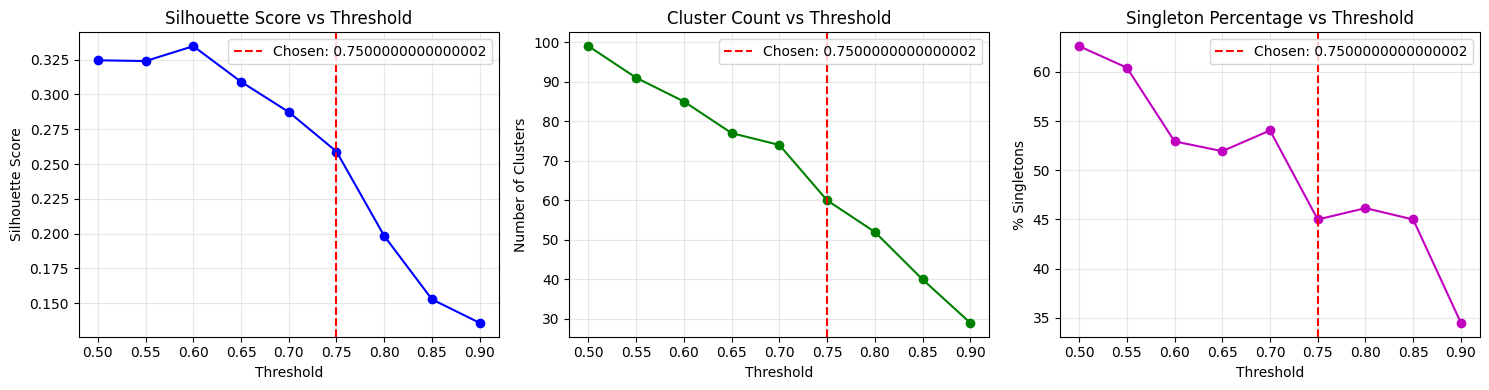

✓ Saved: feature_selection_outputs/mercy_med_adverse_threshold_analysis.png


In [0]:
# Plot threshold analysis
threshold_df = pd.DataFrame(threshold_results)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Silhouette scores
axes[0].plot(threshold_df['threshold'], threshold_df['silhouette'], 'bo-')
axes[0].axvline(x=chosen_threshold, color='r', linestyle='--', label=f'Chosen: {chosen_threshold}')
axes[0].set_xlabel('Threshold')
axes[0].set_ylabel('Silhouette Score')
axes[0].set_title('Silhouette Score vs Threshold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Number of clusters
axes[1].plot(threshold_df['threshold'], threshold_df['n_clusters'], 'go-')
axes[1].axvline(x=chosen_threshold, color='r', linestyle='--', label=f'Chosen: {chosen_threshold}')
axes[1].set_xlabel('Threshold')
axes[1].set_ylabel('Number of Clusters')
axes[1].set_title('Cluster Count vs Threshold')
axes[1].legend()
axes[1].grid(alpha=0.3)

# Singleton percentage
axes[2].plot(threshold_df['threshold'], threshold_df['pct_singletons'], 'mo-')
axes[2].axvline(x=chosen_threshold, color='r', linestyle='--', label=f'Chosen: {chosen_threshold}')
axes[2].set_xlabel('Threshold')
axes[2].set_ylabel('% Singletons')
axes[2].set_title('Singleton Percentage vs Threshold')
axes[2].legend()
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'mercy_med_adverse_threshold_analysis.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Saved: {OUTPUT_DIR}/mercy_med_adverse_threshold_analysis.png")

## Step 1.4: Train Baseline Model (All Features)
 
Train XGBoost model with all features to establish baseline performance.
Evaluation is performed on **train and validation sets only** - test set is held out
until final model evaluation to prevent information leakage during feature selection.

In [0]:
# Check if we can skip this step
if checkpoint_exists("step1_4_baseline_model") and not START_FRESH:
    print_stage("STEP 1.4: TRAIN BASELINE MODEL (from checkpoint)", 4, 7)
    print_progress("Loading from checkpoint: step1_4_baseline_model")
    baseline_checkpoint = load_checkpoint("step1_4_baseline_model")
    baseline_model = baseline_checkpoint['model']
    baseline_metrics = baseline_checkpoint['metrics']
    print_progress(f"Loaded baseline model: Val AUPRC = {baseline_metrics['val']['auprc']:.4f}")
else:
    print_stage("STEP 1.4: TRAIN BASELINE MODEL (ALL FEATURES)", 4, 7)

    # Prepare data splits
    train_mask = df_pandas['SPLIT'] == 'train'
    val_mask = df_pandas['SPLIT'] == 'val'
    test_mask = df_pandas['SPLIT'] == 'test'

    X_train = df_pandas.loc[train_mask].copy()
    y_train = df_pandas.loc[train_mask, 'FUTURE_CRC_EVENT'].copy()

    X_val = df_pandas.loc[val_mask].copy()
    y_val = df_pandas.loc[val_mask, 'FUTURE_CRC_EVENT'].copy()

    X_test = df_pandas.loc[test_mask].copy()
    y_test = df_pandas.loc[test_mask, 'FUTURE_CRC_EVENT'].copy()

    print(f"Training baseline model with {len(feature_cols)} features...")
    print(f"  Train: {len(y_train):,} obs, {y_train.sum():,} events")
    print(f"  Val: {len(y_val):,} obs, {y_val.sum():,} events")
    print(f"  Test: {len(y_test):,} obs, {y_test.sum():,} events")

    start = time.time()
    baseline_model = train_xgboost_model(
        X_train, y_train, X_val, y_val,
        feature_cols, scale_pos_weight
    )
    elapsed = time.time() - start
    print(f"✓ Model trained in {elapsed:.1f}s (best iteration: {baseline_model.best_iteration})")

    # Evaluate on train/val only (test is held out until final evaluation)
    print("\nBaseline performance:")
    baseline_metrics = {
        'train': evaluate_model(baseline_model, X_train, y_train, feature_cols, "Train"),
        'val': evaluate_model(baseline_model, X_val, y_val, feature_cols, "Val")
    }

    # Calculate train-val gap
    baseline_metrics['train_val_gap'] = baseline_metrics['train']['auprc'] - baseline_metrics['val']['auprc']
    print(f"  Train-Val Gap: {baseline_metrics['train_val_gap']:.4f}")
    print("  (Test set held out - evaluated only at final model)")

    # Save checkpoint
    save_checkpoint("step1_4_baseline_model", {
        'model': baseline_model,
        'metrics': baseline_metrics
    })

    # Update tracking CSV
    update_tracking_csv({
        'phase': 'phase1',
        'iteration': 'baseline',
        'n_features': len(feature_cols),
        'n_removed': 0,
        'train_auprc': baseline_metrics['train']['auprc'],
        'val_auprc': baseline_metrics['val']['auprc'],
        'train_val_gap': baseline_metrics['train_val_gap'],
        'val_drop_from_baseline': 0.0,
        'timestamp': datetime.now().isoformat()
    })

print(f"\n✓ Baseline model ready: Val AUPRC = {baseline_metrics['val']['auprc']:.4f}")



[18:25:33] STAGE 4/7: STEP 1.4: TRAIN BASELINE MODEL (from checkpoint)
  [18:25:33] Loading from checkpoint: step1_4_baseline_model
✓ CHECKPOINT LOADED: step1_4_baseline_model
  [18:25:33] Loaded baseline model: Val AUPRC = 0.0252

✓ Baseline model ready: Val AUPRC = 0.0252


## Step 1.5: Compute SHAP with 2:1 Positive Weighting
 
### Why SHAP is Computed on Validation Data
 
We compute SHAP values on the validation set rather than the training set for two reasons:
 
1. **Avoid overfitting to training quirks**: SHAP on training data would reflect feature
   contributions to training patterns, including any noise the model memorized. Validation
   data provides a cleaner signal of generalizable feature importance.
 
2. **Consistent with early stopping**: The model was trained with early stopping on validation
   performance, so its learned structure is already optimized for validation. SHAP on
   validation reflects the model's actual generalization behavior.
 
**Tradeoff**: The validation set has fewer positive cases (~1/3 of training), so importance
estimates have higher variance for rare features. We mitigate this by keeping all positive
cases in the SHAP computation.

In [0]:
# Check if we can skip this step
if checkpoint_exists("step1_5_shap_phase1") and not START_FRESH:
    print_stage("STEP 1.5: COMPUTE SHAP VALUES (from checkpoint)", 5, 7)
    print_progress("Loading from checkpoint: step1_5_shap_phase1")
    shap_checkpoint = load_checkpoint("step1_5_shap_phase1")
    importance_df = shap_checkpoint['importance_df']
    print_progress(f"Loaded SHAP importance for {len(importance_df)} features")
else:
    print_stage("STEP 1.5: COMPUTE SHAP VALUES (2:1 POSITIVE WEIGHTING)", 5, 7)
    print_progress("NOTE: SHAP computation is the slowest step - may take 10-30+ minutes")

    # Use validation set for SHAP
    val_mask = df_pandas['SPLIT'] == 'val'
    X_val = df_pandas.loc[val_mask].copy()
    y_val = df_pandas.loc[val_mask, 'FUTURE_CRC_EVENT'].copy()

    importance_df = compute_shap_values(baseline_model, X_val, y_val, feature_cols)

    # Display top features
    print("\nTop 20 features by SHAP_Combined:")
    print(importance_df[['Rank', 'Feature', 'SHAP_Combined', 'SHAP_Ratio']].head(20).to_string(index=False))

    # Save checkpoint
    save_checkpoint("step1_5_shap_phase1", {
        'importance_df': importance_df
    })

print(f"\n✓ SHAP values computed for {len(importance_df)} features")



[18:25:33] STAGE 5/7: STEP 1.5: COMPUTE SHAP VALUES (from checkpoint)
  [18:25:33] Loading from checkpoint: step1_5_shap_phase1
✓ CHECKPOINT LOADED: step1_5_shap_phase1
  [18:25:34] Loaded SHAP importance for 165 features

✓ SHAP values computed for 165 features


## Step 1.6: Select Cluster Representatives

In [0]:
# Check if we can skip this step
if checkpoint_exists("step1_6_cluster_representatives") and not START_FRESH:
    print_stage("STEP 1.6: SELECT CLUSTER REPRESENTATIVES (from checkpoint)", 6, 7)
    print_progress("Loading from checkpoint: step1_6_cluster_representatives")
    rep_checkpoint = load_checkpoint("step1_6_cluster_representatives")
    selected_features = rep_checkpoint['selected_features']
    selection_df = rep_checkpoint['selection_df']
    print_progress(f"Loaded {len(selected_features)} selected features")
else:
    print_stage("STEP 1.6: SELECT CLUSTER REPRESENTATIVES", 6, 7)

    # Identify which clinical must-keep features exist in the data
    valid_must_keep = [f for f in CLINICAL_MUST_KEEP_FEATURES if f in feature_cols]
    missing_must_keep = [f for f in CLINICAL_MUST_KEEP_FEATURES if f not in feature_cols]

    if missing_must_keep:
        print(f"⚠ Clinical must-keep features not found in data: {missing_must_keep}")
    print(f"Clinical must-keep features to preserve: {len(valid_must_keep)}")

    # Merge cluster assignments with SHAP importance
    cluster_importance = cluster_df.merge(importance_df, on='Feature')

    selected_features = []
    selection_records = []

    # For each cluster, select representative(s)
    for cluster_id in sorted(cluster_importance['Cluster'].unique()):
        cluster_features = cluster_importance[cluster_importance['Cluster'] == cluster_id].copy()
        cluster_size = len(cluster_features)

        # Sort by importance_ratio (descending) - prefer features predictive of positives
        # MED-AVERSE TIEBREAKER: Within the top 5% band of SHAP_Ratio, rank non-med
        # features above med features. This ensures that when two features are nearly
        # equal, the non-medication feature is kept and the med feature is dropped.
        max_ratio_in_cluster = cluster_features['SHAP_Ratio'].max()
        tiebreak_threshold = max_ratio_in_cluster * (1 - MED_TIEBREAK_BAND)
        
        # Add tiebreaker column: 0 = non-med (preferred), 1 = med (deprioritized)
        # Only applies within the tiebreak band
        cluster_features = cluster_features.copy()
        cluster_features['_is_med'] = cluster_features['Feature'].apply(is_medication_feature).astype(int)
        cluster_features['_in_tiebreak_band'] = (cluster_features['SHAP_Ratio'] >= tiebreak_threshold).astype(int)
        
        # Sort by: (1) SHAP_Ratio descending, but within tiebreak band, non-meds first
        # Implementation: sort by (-in_band, is_med, -SHAP_Ratio)
        # This means: features in the top band come first, within that band non-meds 
        # come before meds, then remaining features sorted by SHAP_Ratio
        cluster_features = cluster_features.sort_values(
            by=['_in_tiebreak_band', '_is_med', 'SHAP_Ratio'],
            ascending=[False, True, False]
        )
        
        # Log if tiebreaker changed any ordering
        band_features = cluster_features[cluster_features['_in_tiebreak_band'] == 1]
        n_meds_in_band = band_features['_is_med'].sum()
        if n_meds_in_band > 0 and len(band_features) > n_meds_in_band:
            med_names = band_features[band_features['_is_med'] == 1]['Feature'].tolist()
            print(f"  Cluster {cluster_id}: Med-averse tiebreaker active - {n_meds_in_band} med(s) deprioritized: {med_names}")
        
        # Clean up temp columns before further processing
        cluster_features = cluster_features.drop(columns=['_is_med', '_in_tiebreak_band'])

        # Determine how many to keep (adaptive: drop at most 1-2 per cluster)
        if cluster_size <= 2:
            n_keep = cluster_size  # Keep all for tiny clusters
        elif cluster_size <= 4:
            n_keep = cluster_size - 1  # Drop at most 1
        else:
            n_keep = cluster_size - 2  # Drop at most 2 for larger clusters

        # Select top feature(s)
        kept = cluster_features.head(n_keep)

        for _, row in kept.iterrows():
            selected_features.append(row['Feature'])
            selection_records.append({
                'Feature': row['Feature'],
                'Cluster': cluster_id,
                'Cluster_Size': cluster_size,
                'SHAP_Combined': row['SHAP_Combined'],
                'SHAP_Ratio': row['SHAP_Ratio'],
                'Selection_Reason': f"Top by SHAP_Ratio in cluster of {cluster_size}"
            })

    # Add clinical must-keep features that weren't already selected
    for feat in valid_must_keep:
        if feat not in selected_features:
            # Get the feature's importance info
            feat_info = importance_df[importance_df['Feature'] == feat]
            feat_cluster = cluster_df[cluster_df['Feature'] == feat]['Cluster'].values[0]

            selected_features.append(feat)
            selection_records.append({
                'Feature': feat,
                'Cluster': feat_cluster,
                'Cluster_Size': len(cluster_df[cluster_df['Cluster'] == feat_cluster]),
                'SHAP_Combined': feat_info['SHAP_Combined'].values[0] if len(feat_info) > 0 else 0,
                'SHAP_Ratio': feat_info['SHAP_Ratio'].values[0] if len(feat_info) > 0 else 0,
                'Selection_Reason': "Clinical must-keep feature"
            })
            print(f"  + Added clinical must-keep: {feat}")

    selection_df = pd.DataFrame(selection_records)

    print(f"\nCluster representative selection:")
    print(f"  Original features: {len(feature_cols)}")
    print(f"  Clusters: {len(cluster_importance['Cluster'].unique())}")
    print(f"  Selected features: {len(selected_features)}")
    print(f"  Reduction: {len(feature_cols) - len(selected_features)} features removed ({(len(feature_cols) - len(selected_features))/len(feature_cols)*100:.1f}%)")

    # Show selection summary by cluster size
    print("\nSelection by cluster size:")
    for size_cat in ['1', '2-3', '4-7', '8+']:
        if size_cat == '1':
            mask = selection_df['Cluster_Size'] == 1
        elif size_cat == '2-3':
            mask = (selection_df['Cluster_Size'] >= 2) & (selection_df['Cluster_Size'] <= 3)
        elif size_cat == '4-7':
            mask = (selection_df['Cluster_Size'] >= 4) & (selection_df['Cluster_Size'] <= 7)
        else:
            mask = selection_df['Cluster_Size'] >= 8

        n_selected = mask.sum()
        if n_selected > 0:
            print(f"  Cluster size {size_cat}: {n_selected} features selected")

    # Save checkpoint
    save_checkpoint("step1_6_cluster_representatives", {
        'selected_features': selected_features,
        'selection_df': selection_df
    })

print(f"\n✓ Selected {len(selected_features)} cluster representatives")


[18:25:34] STAGE 6/7: STEP 1.6: SELECT CLUSTER REPRESENTATIVES (from checkpoint)
  [18:25:34] Loading from checkpoint: step1_6_cluster_representatives
✓ CHECKPOINT LOADED: step1_6_cluster_representatives
  [18:25:34] Loaded 139 selected features

✓ Selected 139 cluster representatives


## Step 1.7: Phase 1 Validation Gate

In [0]:
# Check if we can skip this step
if checkpoint_exists("step1_7_phase1_complete") and not START_FRESH:
    print_stage("STEP 1.7: PHASE 1 VALIDATION GATE (from checkpoint)", 7, 7)
    print_progress("Loading from checkpoint: step1_7_phase1_complete")
    phase1_checkpoint = load_checkpoint("step1_7_phase1_complete")
    phase1_features = phase1_checkpoint['phase1_features']
    phase1_metrics = phase1_checkpoint['phase1_metrics']
    phase1_passed = phase1_checkpoint['phase1_passed']
    print_progress(f"Phase 1 complete: {len(phase1_features)} features, passed={phase1_passed}")
else:
    print_stage("STEP 1.7: PHASE 1 VALIDATION GATE", 7, 7)

    # Prepare data
    train_mask = df_pandas['SPLIT'] == 'train'
    val_mask = df_pandas['SPLIT'] == 'val'
    test_mask = df_pandas['SPLIT'] == 'test'

    X_train = df_pandas.loc[train_mask].copy()
    y_train = df_pandas.loc[train_mask, 'FUTURE_CRC_EVENT'].copy()

    X_val = df_pandas.loc[val_mask].copy()
    y_val = df_pandas.loc[val_mask, 'FUTURE_CRC_EVENT'].copy()

    X_test = df_pandas.loc[test_mask].copy()
    y_test = df_pandas.loc[test_mask, 'FUTURE_CRC_EVENT'].copy()

    print(f"Training model with {len(selected_features)} selected features...")

    # Train model with selected features
    phase1_model = train_xgboost_model(
        X_train, y_train, X_val, y_val,
        selected_features, scale_pos_weight
    )

    # Evaluate on train/val only (test is held out until final evaluation)
    print("\nPhase 1 reduced model performance:")
    phase1_metrics = {
        'train': evaluate_model(phase1_model, X_train, y_train, selected_features, "Train"),
        'val': evaluate_model(phase1_model, X_val, y_val, selected_features, "Val")
    }

    phase1_metrics['train_val_gap'] = phase1_metrics['train']['auprc'] - phase1_metrics['val']['auprc']

    # Calculate drops from baseline
    val_drop = (baseline_metrics['val']['auprc'] - phase1_metrics['val']['auprc']) / baseline_metrics['val']['auprc']
    gap_change = phase1_metrics['train_val_gap'] - baseline_metrics['train_val_gap']

    print(f"\nValidation Gate Check:")
    print(f"  Baseline Val AUPRC: {baseline_metrics['val']['auprc']:.4f}")
    print(f"  Phase 1 Val AUPRC:  {phase1_metrics['val']['auprc']:.4f}")
    print(f"  Val AUPRC Drop:     {val_drop*100:.2f}% (threshold: {PHASE1_MAX_VAL_DROP*100}%)")
    print(f"  Train-Val Gap Change: {gap_change:.4f}")

    # Check if passed
    phase1_passed = val_drop <= PHASE1_MAX_VAL_DROP

    if phase1_passed:
        print(f"\n✓ PHASE 1 VALIDATION GATE: PASSED")
        phase1_features = selected_features
    else:
        print(f"\n⚠ PHASE 1 VALIDATION GATE: FAILED")
        print("  Consider: keeping top 2 per cluster, or raising threshold")
        # For now, proceed with selected features but flag the issue
        phase1_features = selected_features

    # Save checkpoint
    save_checkpoint("step1_7_phase1_complete", {
        'phase1_features': phase1_features,
        'phase1_metrics': phase1_metrics,
        'phase1_passed': phase1_passed,
        'val_drop': val_drop,
        'gap_change': gap_change
    })

    # Update tracking CSV
    update_tracking_csv({
        'phase': 'phase1',
        'iteration': 'cluster_reduction',
        'n_features': len(phase1_features),
        'n_removed': len(feature_cols) - len(phase1_features),
        'train_auprc': phase1_metrics['train']['auprc'],
        'val_auprc': phase1_metrics['val']['auprc'],
        'train_val_gap': phase1_metrics['train_val_gap'],
        'val_drop_from_baseline': val_drop,
        'timestamp': datetime.now().isoformat()
    })

print(f"\n✓ Phase 1 complete: {len(phase1_features)} features")


[18:25:34] STAGE 7/7: STEP 1.7: PHASE 1 VALIDATION GATE (from checkpoint)
  [18:25:34] Loading from checkpoint: step1_7_phase1_complete
✓ CHECKPOINT LOADED: step1_7_phase1_complete
  [18:25:35] Phase 1 complete: 139 features, passed=True

✓ Phase 1 complete: 139 features


---
# PHASE 2: Iterative SHAP Winnowing
---
 
Iteratively remove low-importance features while monitoring validation performance.
 
**Key controls:**
- **Validation gates**: Stop if val AUPRC drops >5% or train-val gap increases >0.02
- **Clinical must-keep**: Never remove clinically important features (weight loss, GI bleeding, etc.)
- **Protected features**: Never remove features in top 50% by SHAP ratio
- **Test holdout**: All decisions based on validation metrics only; test evaluated at final model

## Phase 2 Iteration Loop

In [0]:
print_stage("PHASE 2: ITERATIVE SHAP WINNOWING")

# Initialize Phase 2
current_features = phase1_features.copy()
iteration = 0
stop_reason = None
prev_metrics = phase1_metrics.copy()  # Track previous iteration for comparison

# Check for existing Phase 2 checkpoints to resume
phase2_checkpoints = [cp for cp in list_checkpoints() if cp.startswith("step2_iter") and cp.endswith("_complete")]
if phase2_checkpoints and not START_FRESH:
    # Find the latest complete iteration
    iter_nums = []
    for cp in phase2_checkpoints:
        try:
            iter_num = int(cp.split("_")[1].replace("iter", ""))
            iter_nums.append(iter_num)
        except:
            pass

    if iter_nums:
        last_iter = max(iter_nums)
        print_progress(f"Found Phase 2 checkpoint at iteration {last_iter}. Resuming...")

        last_checkpoint = load_checkpoint(f"step2_iter{last_iter}_complete")
        current_features = last_checkpoint['current_features']
        iteration = last_iter

        # Update prev_metrics from checkpoint for comparison
        if 'metrics' in last_checkpoint:
            prev_metrics = last_checkpoint['metrics'].copy()

        # Check if we should stop
        if last_checkpoint.get('stop_triggered', False):
            stop_reason = last_checkpoint.get('stop_reason', 'Unknown')
            print_progress(f"Previous iteration triggered stop: {stop_reason}")

print_progress(f"Starting Phase 2 from iteration {iteration}")
print_progress(f"Current features: {len(current_features)}")
print_progress(f"Max removals: {MAX_REMOVALS_EARLY} (iter 1-{LATE_PHASE_ITERATION}), {MAX_REMOVALS_LATE} (iter {LATE_PHASE_ITERATION+1}+)")
print_progress(f"Min features threshold: {MIN_FEATURES_THRESHOLD}")
print_progress("Each iteration: Train model → Compute SHAP → Identify removals → Validate")
print("="*70)


[18:25:35] PHASE 2: ITERATIVE SHAP WINNOWING
  [18:25:36] Found Phase 2 checkpoint at iteration 15. Resuming...
✓ CHECKPOINT LOADED: step2_iter15_complete
  [18:25:37] Starting Phase 2 from iteration 15
  [18:25:37] Current features: 56
  [18:25:37] Max removals: 10 (iter 1-5), 5 (iter 6+)
  [18:25:37] Min features threshold: 25
  [18:25:37] Each iteration: Train model → Compute SHAP → Identify removals → Validate


## Run Phase 2 Iterations

In [0]:
# Prepare data splits (needed for iterations)
train_mask = df_pandas['SPLIT'] == 'train'
val_mask = df_pandas['SPLIT'] == 'val'
test_mask = df_pandas['SPLIT'] == 'test'

X_train = df_pandas.loc[train_mask].copy()
y_train = df_pandas.loc[train_mask, 'FUTURE_CRC_EVENT'].copy()

X_val = df_pandas.loc[val_mask].copy()
y_val = df_pandas.loc[val_mask, 'FUTURE_CRC_EVENT'].copy()

X_test = df_pandas.loc[test_mask].copy()
y_test = df_pandas.loc[test_mask, 'FUTURE_CRC_EVENT'].copy()

# Main iteration loop
while stop_reason is None:
    iteration += 1
    iter_start_time = time.time()

    # Determine max removals for this iteration (gradual reduction)
    max_removals_this_iter = MAX_REMOVALS_EARLY if iteration <= LATE_PHASE_ITERATION else MAX_REMOVALS_LATE

    print_stage(f"PHASE 2 - ITERATION {iteration}")
    print_progress(f"Current features: {len(current_features)}")
    print_progress(f"Target: Remove up to {max_removals_this_iter} low-value features")

    # =========================================================================
    # Step 2.1: Train Model
    # =========================================================================
    checkpoint_name = f"step2_iter{iteration}_model"

    if checkpoint_exists(checkpoint_name) and not START_FRESH:
        print_progress(f"Step 2.{iteration}.1: Loading model from checkpoint...")
        model_checkpoint = load_checkpoint(checkpoint_name)
        iter_model = model_checkpoint['model']
        iter_metrics = model_checkpoint['metrics']
        # Evaluate test if not in checkpoint (for older checkpoints)
        if 'test' not in iter_metrics:
            iter_metrics['test'] = evaluate_model(iter_model, X_test, y_test, current_features, "Test")
        print_progress(f"Model loaded: Val AUPRC = {iter_metrics['val']['auprc']:.4f}, Test AUPRC = {iter_metrics['test']['auprc']:.4f}")
    else:
        print_progress(f"Step 2.{iteration}.1: Training model with {len(current_features)} features...")

        iter_model = train_xgboost_model(
            X_train, y_train, X_val, y_val,
            current_features, scale_pos_weight
        )

        iter_metrics = {
            'train': evaluate_model(iter_model, X_train, y_train, current_features, "Train"),
            'val': evaluate_model(iter_model, X_val, y_val, current_features, "Val"),
            'test': evaluate_model(iter_model, X_test, y_test, current_features, "Test")  # Track for post-hoc analysis
        }
        iter_metrics['train_val_gap'] = iter_metrics['train']['auprc'] - iter_metrics['val']['auprc']
        print(f"  Test AUPRC: {iter_metrics['test']['auprc']:.4f} (tracking only - not used for decisions)")

        save_checkpoint(checkpoint_name, {
            'model': iter_model,
            'metrics': iter_metrics
        })

    # =========================================================================
    # Step 2.2: Compute SHAP
    # =========================================================================
    checkpoint_name = f"step2_iter{iteration}_shap"

    if checkpoint_exists(checkpoint_name) and not START_FRESH:
        print_progress(f"Step 2.{iteration}.2: Loading SHAP values from checkpoint...")
        shap_checkpoint = load_checkpoint(checkpoint_name)
        iter_importance_df = shap_checkpoint['importance_df']
        print_progress(f"SHAP loaded for {len(iter_importance_df)} features")
    else:
        print_progress(f"Step 2.{iteration}.2: Computing SHAP values (this is the slow step)...")

        iter_importance_df = compute_shap_values(iter_model, X_val, y_val, current_features)

        save_checkpoint(checkpoint_name, {
            'importance_df': iter_importance_df
        })

    # =========================================================================
    # Step 2.3: Identify Removal Candidates (ORIGINAL METHODOLOGY)
    # =========================================================================
    # From CRC_ITER1_MODEL-PREVALENCE.py:
    # Feature must meet AT LEAST 2 of 3 criteria:
    #   1. Near-zero SHAP importance (< ZERO_SHAP_THRESHOLD)
    #   2. Negative-biased ratio (< NEG_BIAS_RATIO_THRESHOLD)
    #   3. Bottom percentile by SHAP (< BOTTOM_PERCENTILE)
    #
    # Cluster-specific removal caps:
    #   - Singleton (1): max 1 removal
    #   - Small (2-3): max 2 removals, leave at least 1
    #   - Medium (4-7): max 2 removals, leave at least 3
    #   - Large (8+): max 3 removals, leave at least 5
    #   - High-importance clusters (top 20%): max 1 removal
    # =========================================================================
    print_progress(f"Step 2.{iteration}.3: Identifying removal candidates (original methodology)...")

    n_features = len(current_features)

    # Get cluster assignments for current features
    current_selection = selection_df[selection_df['Feature'].isin(current_features)].copy()

    # Merge SHAP importance with cluster info
    iter_importance_with_cluster = iter_importance_df.merge(
        current_selection[['Feature', 'Cluster']],
        on='Feature',
        how='left'
    )

    # Clinical must-keep features are always protected
    clinical_protected = set(f for f in CLINICAL_MUST_KEEP_FEATURES if f in current_features)

    # -------------------------------------------------------------------------
    # Calculate features meeting each criterion
    # -------------------------------------------------------------------------
    zero_importance_features = set(
        iter_importance_df[iter_importance_df['SHAP_Combined'] < ZERO_SHAP_THRESHOLD]['Feature']
    )
    neg_biased_features = set(
        iter_importance_df[iter_importance_df['SHAP_Ratio'] < NEG_BIAS_RATIO_THRESHOLD]['Feature']
    )
    importance_percentile = iter_importance_df['SHAP_Combined'].quantile(BOTTOM_PERCENTILE / 100)
    bottom_features = set(
        iter_importance_df[iter_importance_df['SHAP_Combined'] < importance_percentile]['Feature']
    )

    # Feature must meet AT LEAST 2 of 3 criteria
    features_meeting_two_criteria = (
        (zero_importance_features & neg_biased_features) |
        (zero_importance_features & bottom_features) |
        (neg_biased_features & bottom_features)
    )
    features_meeting_all = zero_importance_features & neg_biased_features & bottom_features

    # Remove clinical protected from candidates
    features_flagged = features_meeting_two_criteria - clinical_protected

    print(f"  Removal criteria:")
    print(f"    Near-zero SHAP (<{ZERO_SHAP_THRESHOLD}): {len(zero_importance_features)}")
    print(f"    Negative-biased (<{NEG_BIAS_RATIO_THRESHOLD}): {len(neg_biased_features)}")
    print(f"    Bottom {BOTTOM_PERCENTILE}% (threshold={importance_percentile:.6f}): {len(bottom_features)}")
    print(f"    Meeting ALL 3 criteria: {len(features_meeting_all)}")
    print(f"    Meeting 2+ criteria: {len(features_meeting_two_criteria)}")
    print(f"    Flagged (excl. clinical): {len(features_flagged)}")

    # -------------------------------------------------------------------------
    # Analyze flagged features by cluster with removal caps
    # -------------------------------------------------------------------------
    # IMPORTANT: Use ORIGINAL cluster sizes from Phase 1 (stored in selection_df)
    # not current sizes. This matches the original methodology which reads from
    # the cluster CSV file each iteration.
    # -------------------------------------------------------------------------

    # Get original cluster sizes from selection_df (created in Phase 1)
    original_cluster_sizes = selection_df.groupby('Cluster')['Cluster_Size'].first().to_dict()

    cluster_removal_candidates = {}

    for cluster_id in iter_importance_with_cluster['Cluster'].dropna().unique():
        cluster_features = iter_importance_with_cluster[iter_importance_with_cluster['Cluster'] == cluster_id]

        # Use ORIGINAL cluster size, not current size
        cluster_size = original_cluster_sizes.get(cluster_id, len(cluster_features))

        # Find flagged features in this cluster
        flagged_in_cluster = list(set(cluster_features['Feature'].tolist()) & features_flagged)

        if not flagged_in_cluster:
            continue

        # Get SHAP scores for flagged features
        flagged_with_scores = []
        for feat in flagged_in_cluster:
            feat_row = iter_importance_df[iter_importance_df['Feature'] == feat]
            if len(feat_row) > 0:
                shap_val = feat_row['SHAP_Combined'].values[0]
                ratio_val = feat_row['SHAP_Ratio'].values[0]
                meets_all = feat in features_meeting_all
                flagged_with_scores.append((feat, shap_val, ratio_val, meets_all))

        # Sort by: (1) meets all criteria first, then (2) SHAP score ascending
        flagged_with_scores.sort(key=lambda x: (not x[3], x[1]))

        cluster_removal_candidates[cluster_id] = {
            'size': cluster_size,  # Original size from Phase 1
            'current_size': len(cluster_features),  # Current size for logging
            'flagged': flagged_with_scores,
            'max_shap': cluster_features['SHAP_Combined'].max()
        }

    # -------------------------------------------------------------------------
    # Apply cluster removal rules (from original methodology)
    # -------------------------------------------------------------------------
    removals_by_priority = []
    shap_80th = iter_importance_df['SHAP_Combined'].quantile(0.80)

    for cluster_id, cluster_info in cluster_removal_candidates.items():
        cluster_size = cluster_info['size']
        flagged_list = cluster_info['flagged']
        max_shap = cluster_info['max_shap']

        # Cluster-specific removal caps
        if cluster_size == 1:
            max_remove = 1  # Singleton - can remove if flagged
        elif cluster_size <= 3:
            max_remove = min(2, cluster_size - 1)  # Small - max 2, leave at least 1
        elif cluster_size <= 7:
            max_remove = min(2, cluster_size - 3) if cluster_size > 3 else 0  # Medium
        else:
            max_remove = min(3, cluster_size - 5) if cluster_size > 5 else 0  # Large

        # Additional protection for high-importance clusters
        if max_shap > shap_80th:
            max_remove = min(max_remove, 1)

        # Select worst features up to limit
        for i, (feat, shap_val, ratio_val, meets_all) in enumerate(flagged_list[:max_remove]):
            # MED-AVERSE: Medication features get a small penalty (lower score = 
            # removed first). When two features have identical SHAP, the med feature
            # will be removed before the non-med feature.
            med_penalty = -MED_PRIORITY_PENALTY if is_medication_feature(feat) else 0
            priority_score = shap_val * 1000 + (0 if meets_all else 1) + med_penalty
            removals_by_priority.append((feat, shap_val, ratio_val, cluster_id, cluster_size, priority_score))

    # Sort by priority score and apply global limit (iteration-aware)
    removals_by_priority.sort(key=lambda x: x[5])
    final_removals = removals_by_priority[:max_removals_this_iter]

    features_to_remove = [feat for feat, _, _, _, _, _ in final_removals]

    # Summary statistics
    print(f"\n  Cluster-aware removal:")
    print(f"    Total flagged across clusters: {len(removals_by_priority)}")
    print(f"    After global cap ({max_removals_this_iter}): {len(features_to_remove)}")
    print(f"    Clinical protected: {len(clinical_protected)}")

    if features_to_remove:
        n_med_removed = sum(1 for f in features_to_remove if is_medication_feature(f))
        n_nonmed_removed = len(features_to_remove) - n_med_removed
        print(f"\n  Features to remove ({len(features_to_remove)}): {n_med_removed} medication, {n_nonmed_removed} non-medication")
        for feat, shap_val, ratio_val, cluster_id, cluster_size, _ in final_removals[:10]:
            med_tag = " [MED]" if is_medication_feature(feat) else ""
            print(f"    - {feat:<45} SHAP={shap_val:.6f}, Ratio={ratio_val:.3f}, Cluster {cluster_id} (size={cluster_size}){med_tag}")
        if len(final_removals) > 10:
            print(f"    ... and {len(final_removals) - 10} more")

    # =========================================================================
    # Step 2.4: Validation Gate
    # =========================================================================
    print_progress(f"Step 2.{iteration}.4: Checking validation gates...")

    # Track metrics for post-hoc analysis (NOT used for stopping decisions)
    val_change = iter_metrics['val']['auprc'] - prev_metrics['val']['auprc']
    test_change = iter_metrics['test']['auprc'] - prev_metrics.get('test', {}).get('auprc', iter_metrics['test']['auprc'])
    val_drop_from_baseline = (baseline_metrics['val']['auprc'] - iter_metrics['val']['auprc']) / baseline_metrics['val']['auprc']

    print(f"  Val AUPRC:  {iter_metrics['val']['auprc']:.4f} (change: {val_change:+.4f})")
    print(f"  Test AUPRC: {iter_metrics['test']['auprc']:.4f} (change: {test_change:+.4f})")
    print(f"  Train-Val Gap: {iter_metrics['train_val_gap']:.4f}")
    print(f"  Features remaining: {len(current_features)}")

    # Simple stop conditions - run until we hit limits
    # Metrics are tracked but NOT used to influence stopping
    if len(current_features) - len(features_to_remove) < MIN_FEATURES_THRESHOLD:
        stop_reason = f"Would go below {MIN_FEATURES_THRESHOLD} features"
    elif len(features_to_remove) == 0:
        if len(current_features) > MIN_FEATURES_THRESHOLD + 5:
            # Force-remove the 2 lowest-SHAP features
            lowest_features = iter_importance_df.nsmallest(2, 'SHAP_Combined')['Feature'].tolist()
            features_to_remove = lowest_features
            print(f"  No features meet 2-of-3 criteria -- force-removing {len(lowest_features)} lowest: {lowest_features}")
        else:
            stop_reason = "No features meet removal criteria"

    # =========================================================================
    # Step 2.5: Log & Checkpoint
    # =========================================================================

    # Update tracking CSV - includes test for post-hoc sweet spot analysis
    update_tracking_csv({
        'phase': 'phase2',
        'iteration': iteration,
        'n_features': len(current_features),
        'n_removed': len(features_to_remove) if stop_reason is None else 0,
        'train_auprc': iter_metrics['train']['auprc'],
        'val_auprc': iter_metrics['val']['auprc'],
        'test_auprc': iter_metrics['test']['auprc'],
        'train_val_gap': iter_metrics['train_val_gap'],
        'val_change_from_prev': val_change,
        'test_change_from_prev': test_change,
        'val_drop_from_baseline': val_drop_from_baseline,
        'stop_triggered': stop_reason is not None,
        'stop_reason': stop_reason if stop_reason else '',
        'timestamp': datetime.now().isoformat()
    })

    if stop_reason:
        print(f"\n>>> STOP CONDITION TRIGGERED: {stop_reason}")
        print(f">>> Keeping features from iteration {iteration}")

        # Save final checkpoint
        save_checkpoint(f"step2_iter{iteration}_complete", {
            'current_features': current_features,
            'metrics': iter_metrics,
            'features_removed': [],
            'stop_triggered': True,
            'stop_reason': stop_reason
        })
        break
    else:
        # Remove features and continue
        print(f"\n>>> Removing {len(features_to_remove)} features:")
        for feat in features_to_remove[:10]:
            shap_val = iter_importance_df[iter_importance_df['Feature'] == feat]['SHAP_Combined'].values[0]
            ratio_val = iter_importance_df[iter_importance_df['Feature'] == feat]['SHAP_Ratio'].values[0]
            print(f"    - {feat} (SHAP={shap_val:.6f}, Ratio={ratio_val:.3f})")
        if len(features_to_remove) > 10:
            print(f"    ... and {len(features_to_remove) - 10} more")

        # Update feature list
        previous_features = current_features.copy()
        current_features = [f for f in current_features if f not in features_to_remove]

        # Save checkpoint
        save_checkpoint(f"step2_iter{iteration}_complete", {
            'current_features': current_features,
            'previous_features': previous_features,
            'metrics': iter_metrics,
            'features_removed': features_to_remove,
            'stop_triggered': False,
            'stop_reason': None
        })

        # Update previous metrics for next iteration comparison
        prev_metrics = iter_metrics.copy()

        iter_elapsed = time.time() - iter_start_time
        print_progress(f"Iteration {iteration} complete in {iter_elapsed:.1f}s. Features: {len(previous_features)} → {len(current_features)}")




[18:25:38] PHASE 2 - ITERATION 16
  [18:25:38] Current features: 56
  [18:25:38] Target: Remove up to 5 low-value features
  [18:25:38] Step 2.16.1: Training model with 56 features...
  [18:25:38] Training XGBoost with 56 features...
  [18:25:38] Train: 601,399 obs, 2,178 events | Val: 128,145 obs, 466 events


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run luxuriant-doe-147 at: https://adb-2845170968234247.7.azuredatabricks.net/ml/experiments/891b290089344741977776a75f6d34a4/runs/8d26da0c30d04056b2cc8bcd51a4f13f
🧪 View experiment at: https://adb-2845170968234247.7.azuredatabricks.net/ml/experiments/891b290089344741977776a75f6d34a4
  [18:25:52] Model trained in 14.1s (best iteration: 6)
  Train: AUPRC=0.0299 (8.3x lift), AUROC=0.7874
  Val: AUPRC=0.0259 (7.1x lift), AUROC=0.7775
  Test: AUPRC=0.0236 (6.8x lift), AUROC=0.7723
  Test AUPRC: 0.0236 (tracking only - not used for decisions)
✓ CHECKPOINT SAVED: step2_iter16_model
  [18:26:04] Step 2.16.2: Computing SHAP values (this is the slow step)...
  [18:26:04] Starting SHAP computation...
  [18:26:04] Positive cases: 466 | Negative cases: 127,679
  [18:26:04] Creating TreeExplainer...
  [18:26:04] Computing SHAP for 466 positive cases (this may take a while)...
  [18:26:04] Positive cases complete in 0.1s (5853 cases/sec)
  [18:26:04] Computing SHAP for 127,679 negative cases (

[18:26:04] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


  [18:26:05] Negative cases complete in 0.2s (817370 cases/sec)
  [18:26:05] Calculating importance metrics...
  [18:26:05] SHAP computation complete in 0.3s total
✓ CHECKPOINT SAVED: step2_iter16_shap
  [18:26:05] Step 2.16.3: Identifying removal candidates (original methodology)...
  Removal criteria:
    Near-zero SHAP (<0.0005): 42
    Negative-biased (<0.25): 36
    Bottom 12% (threshold=0.000000): 0
    Meeting ALL 3 criteria: 0
    Meeting 2+ criteria: 36
    Flagged (excl. clinical): 36

  Cluster-aware removal:
    Total flagged across clusters: 27
    After global cap (5): 5
    Clinical protected: 0

  Features to remove (5): 3 medication, 2 non-medication
    - inp_med_inp_any_hospitalization               SHAP=0.000000, Ratio=0.000, Cluster 50 (size=16) [MED]
    - inp_med_inp_obstruction_pattern               SHAP=0.000000, Ratio=0.000, Cluster 50 (size=16) [MED]
    - out_med_ibd_meds_recency                      SHAP=0.000000, Ratio=0.000, Cluster 35 (size=2) [MED]
    

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run agreeable-newt-842 at: https://adb-2845170968234247.7.azuredatabricks.net/ml/experiments/891b290089344741977776a75f6d34a4/runs/83a1f05c32a043f4938ba23bff1ad877
🧪 View experiment at: https://adb-2845170968234247.7.azuredatabricks.net/ml/experiments/891b290089344741977776a75f6d34a4
  [18:27:54] Model trained in 108.5s (best iteration: 1980)
  Train: AUPRC=0.0891 (24.6x lift), AUROC=0.8765
  Val: AUPRC=0.0559 (15.4x lift), AUROC=0.8090
  Test: AUPRC=0.0520 (14.9x lift), AUROC=0.8259
  Test AUPRC: 0.0520 (tracking only - not used for decisions)
✓ CHECKPOINT SAVED: step2_iter17_model
  [18:28:06] Step 2.17.2: Computing SHAP values (this is the slow step)...
  [18:28:06] Starting SHAP computation...
  [18:28:06] Positive cases: 466 | Negative cases: 127,679
  [18:28:06] Creating TreeExplainer...


[18:28:06] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


  [18:28:06] Computing SHAP for 466 positive cases (this may take a while)...
  [18:28:06] Positive cases complete in 0.1s (4551 cases/sec)
  [18:28:07] Computing SHAP for 127,679 negative cases (this may take a while)...
  [18:28:12] Negative cases complete in 5.9s (21587 cases/sec)
  [18:28:12] Calculating importance metrics...
  [18:28:12] SHAP computation complete in 6.5s total
✓ CHECKPOINT SAVED: step2_iter17_shap
  [18:28:13] Step 2.17.3: Identifying removal candidates (original methodology)...
  Removal criteria:
    Near-zero SHAP (<0.0005): 0
    Negative-biased (<0.25): 0
    Bottom 12% (threshold=0.005285): 6
    Meeting ALL 3 criteria: 0
    Meeting 2+ criteria: 0
    Flagged (excl. clinical): 0

  Cluster-aware removal:
    Total flagged across clusters: 0
    After global cap (5): 0
    Clinical protected: 0
  [18:28:13] Step 2.17.4: Checking validation gates...
  Val AUPRC:  0.0559 (change: +0.0300)
  Test AUPRC: 0.0520 (change: +0.0284)
  Train-Val Gap: 0.0333
  Feature

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run respected-colt-353 at: https://adb-2845170968234247.7.azuredatabricks.net/ml/experiments/891b290089344741977776a75f6d34a4/runs/d292e89a96744846acf9e1adfe38be54
🧪 View experiment at: https://adb-2845170968234247.7.azuredatabricks.net/ml/experiments/891b290089344741977776a75f6d34a4
  [18:29:57] Model trained in 102.9s (best iteration: 1969)
  Train: AUPRC=0.0894 (24.7x lift), AUROC=0.8770
  Val: AUPRC=0.0560 (15.4x lift), AUROC=0.8086
  Test: AUPRC=0.0509 (14.6x lift), AUROC=0.8279
  Test AUPRC: 0.0509 (tracking only - not used for decisions)
✓ CHECKPOINT SAVED: step2_iter18_model
  [18:30:08] Step 2.18.2: Computing SHAP values (this is the slow step)...
  [18:30:08] Starting SHAP computation...
  [18:30:08] Positive cases: 466 | Negative cases: 127,679
  [18:30:08] Creating TreeExplainer...


[18:30:08] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


  [18:30:09] Computing SHAP for 466 positive cases (this may take a while)...
  [18:30:09] Positive cases complete in 0.1s (3128 cases/sec)
  [18:30:09] Computing SHAP for 127,679 negative cases (this may take a while)...
  [18:30:15] Negative cases complete in 6.0s (21399 cases/sec)
  [18:30:15] Calculating importance metrics...
  [18:30:15] SHAP computation complete in 6.6s total
✓ CHECKPOINT SAVED: step2_iter18_shap
  [18:30:15] Step 2.18.3: Identifying removal candidates (original methodology)...
  Removal criteria:
    Near-zero SHAP (<0.0005): 0
    Negative-biased (<0.25): 0
    Bottom 12% (threshold=0.007703): 6
    Meeting ALL 3 criteria: 0
    Meeting 2+ criteria: 0
    Flagged (excl. clinical): 0

  Cluster-aware removal:
    Total flagged across clusters: 0
    After global cap (5): 0
    Clinical protected: 0
  [18:30:15] Step 2.18.4: Checking validation gates...
  Val AUPRC:  0.0560 (change: +0.0002)
  Test AUPRC: 0.0509 (change: -0.0011)
  Train-Val Gap: 0.0334
  Feature

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run gregarious-ray-777 at: https://adb-2845170968234247.7.azuredatabricks.net/ml/experiments/891b290089344741977776a75f6d34a4/runs/f0141c6143fc4963857bdad95d52c2fa
🧪 View experiment at: https://adb-2845170968234247.7.azuredatabricks.net/ml/experiments/891b290089344741977776a75f6d34a4
  [18:31:50] Model trained in 94.5s (best iteration: 1999)
  Train: AUPRC=0.0882 (24.4x lift), AUROC=0.8774
  Val: AUPRC=0.0555 (15.3x lift), AUROC=0.8072
  Test: AUPRC=0.0505 (14.4x lift), AUROC=0.8260
  Test AUPRC: 0.0505 (tracking only - not used for decisions)
✓ CHECKPOINT SAVED: step2_iter19_model
  [18:32:02] Step 2.19.2: Computing SHAP values (this is the slow step)...
  [18:32:02] Starting SHAP computation...
  [18:32:02] Positive cases: 466 | Negative cases: 127,679
  [18:32:02] Creating TreeExplainer...


[18:32:02] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


  [18:32:02] Computing SHAP for 466 positive cases (this may take a while)...
  [18:32:02] Positive cases complete in 0.1s (4371 cases/sec)
  [18:32:02] Computing SHAP for 127,679 negative cases (this may take a while)...
  [18:32:08] Negative cases complete in 5.9s (21738 cases/sec)
  [18:32:08] Calculating importance metrics...
  [18:32:08] SHAP computation complete in 6.4s total
✓ CHECKPOINT SAVED: step2_iter19_shap
  [18:32:08] Step 2.19.3: Identifying removal candidates (original methodology)...
  Removal criteria:
    Near-zero SHAP (<0.0005): 0
    Negative-biased (<0.25): 0
    Bottom 12% (threshold=0.009983): 6
    Meeting ALL 3 criteria: 0
    Meeting 2+ criteria: 0
    Flagged (excl. clinical): 0

  Cluster-aware removal:
    Total flagged across clusters: 0
    After global cap (5): 0
    Clinical protected: 0
  [18:32:08] Step 2.19.4: Checking validation gates...
  Val AUPRC:  0.0555 (change: -0.0005)
  Test AUPRC: 0.0505 (change: -0.0004)
  Train-Val Gap: 0.0327
  Feature

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run kindly-trout-54 at: https://adb-2845170968234247.7.azuredatabricks.net/ml/experiments/891b290089344741977776a75f6d34a4/runs/b4f0d220cb914a78bb34392bec0efc9f
🧪 View experiment at: https://adb-2845170968234247.7.azuredatabricks.net/ml/experiments/891b290089344741977776a75f6d34a4
  [18:33:46] Model trained in 96.9s (best iteration: 1997)
  Train: AUPRC=0.0893 (24.7x lift), AUROC=0.8771
  Val: AUPRC=0.0573 (15.8x lift), AUROC=0.8087
  Test: AUPRC=0.0502 (14.4x lift), AUROC=0.8287
  Test AUPRC: 0.0502 (tracking only - not used for decisions)
✓ CHECKPOINT SAVED: step2_iter20_model
  [18:33:57] Step 2.20.2: Computing SHAP values (this is the slow step)...
  [18:33:57] Starting SHAP computation...
  [18:33:57] Positive cases: 466 | Negative cases: 127,679
  [18:33:57] Creating TreeExplainer...


[18:33:57] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


  [18:33:57] Computing SHAP for 466 positive cases (this may take a while)...
  [18:33:57] Positive cases complete in 0.1s (4925 cases/sec)
  [18:33:57] Computing SHAP for 127,679 negative cases (this may take a while)...
  [18:34:03] Negative cases complete in 6.0s (21439 cases/sec)
  [18:34:03] Calculating importance metrics...
  [18:34:03] SHAP computation complete in 6.5s total
✓ CHECKPOINT SAVED: step2_iter20_shap
  [18:34:04] Step 2.20.3: Identifying removal candidates (original methodology)...
  Removal criteria:
    Near-zero SHAP (<0.0005): 0
    Negative-biased (<0.25): 0
    Bottom 12% (threshold=0.013541): 6
    Meeting ALL 3 criteria: 0
    Meeting 2+ criteria: 0
    Flagged (excl. clinical): 0

  Cluster-aware removal:
    Total flagged across clusters: 0
    After global cap (5): 0
    Clinical protected: 0
  [18:34:04] Step 2.20.4: Checking validation gates...
  Val AUPRC:  0.0573 (change: +0.0018)
  Test AUPRC: 0.0502 (change: -0.0003)
  Train-Val Gap: 0.0320
  Feature

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run glamorous-smelt-43 at: https://adb-2845170968234247.7.azuredatabricks.net/ml/experiments/891b290089344741977776a75f6d34a4/runs/ada4995e29c34584bcb537ab426d666d
🧪 View experiment at: https://adb-2845170968234247.7.azuredatabricks.net/ml/experiments/891b290089344741977776a75f6d34a4
  [18:35:48] Model trained in 103.5s (best iteration: 1997)
  Train: AUPRC=0.0884 (24.4x lift), AUROC=0.8764
  Val: AUPRC=0.0583 (16.0x lift), AUROC=0.8084
  Test: AUPRC=0.0496 (14.2x lift), AUROC=0.8262
  Test AUPRC: 0.0496 (tracking only - not used for decisions)
✓ CHECKPOINT SAVED: step2_iter21_model
  [18:35:58] Step 2.21.2: Computing SHAP values (this is the slow step)...
  [18:35:58] Starting SHAP computation...
  [18:35:58] Positive cases: 466 | Negative cases: 127,679
  [18:35:58] Creating TreeExplainer...


[18:35:58] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


  [18:35:59] Computing SHAP for 466 positive cases (this may take a while)...
  [18:35:59] Positive cases complete in 0.1s (4500 cases/sec)
  [18:35:59] Computing SHAP for 127,679 negative cases (this may take a while)...
  [18:36:05] Negative cases complete in 5.9s (21798 cases/sec)
  [18:36:05] Calculating importance metrics...
  [18:36:05] SHAP computation complete in 6.4s total
✓ CHECKPOINT SAVED: step2_iter21_shap
  [18:36:05] Step 2.21.3: Identifying removal candidates (original methodology)...
  Removal criteria:
    Near-zero SHAP (<0.0005): 0
    Negative-biased (<0.25): 0
    Bottom 12% (threshold=0.014481): 6
    Meeting ALL 3 criteria: 0
    Meeting 2+ criteria: 0
    Flagged (excl. clinical): 0

  Cluster-aware removal:
    Total flagged across clusters: 0
    After global cap (5): 0
    Clinical protected: 0
  [18:36:05] Step 2.21.4: Checking validation gates...
  Val AUPRC:  0.0583 (change: +0.0009)
  Test AUPRC: 0.0496 (change: -0.0006)
  Train-Val Gap: 0.0302
  Feature

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run adorable-roo-202 at: https://adb-2845170968234247.7.azuredatabricks.net/ml/experiments/891b290089344741977776a75f6d34a4/runs/4f8b487e78b8415da233d62ee5a773a4
🧪 View experiment at: https://adb-2845170968234247.7.azuredatabricks.net/ml/experiments/891b290089344741977776a75f6d34a4
  [18:36:25] Model trained in 19.0s (best iteration: 111)
  Train: AUPRC=0.0513 (14.2x lift), AUROC=0.7963
  Val: AUPRC=0.0278 (7.6x lift), AUROC=0.7750
  Test: AUPRC=0.0367 (10.5x lift), AUROC=0.7725
  Test AUPRC: 0.0367 (tracking only - not used for decisions)
✓ CHECKPOINT SAVED: step2_iter22_model
  [18:36:35] Step 2.22.2: Computing SHAP values (this is the slow step)...
  [18:36:35] Starting SHAP computation...
  [18:36:35] Positive cases: 466 | Negative cases: 127,679
  [18:36:35] Creating TreeExplainer...
  [18:36:35] Computing SHAP for 466 positive cases (this may take a while)...
  [18:36:35] Positive cases complete in 0.1s (7240 cases/sec)


[18:36:35] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


  [18:36:35] Computing SHAP for 127,679 negative cases (this may take a while)...
  [18:36:35] Negative cases complete in 0.4s (290361 cases/sec)
  [18:36:35] Calculating importance metrics...
  [18:36:35] SHAP computation complete in 0.6s total
✓ CHECKPOINT SAVED: step2_iter22_shap
  [18:36:35] Step 2.22.3: Identifying removal candidates (original methodology)...
  Removal criteria:
    Near-zero SHAP (<0.0005): 7
    Negative-biased (<0.25): 4
    Bottom 12% (threshold=0.000376): 5
    Meeting ALL 3 criteria: 4
    Meeting 2+ criteria: 5
    Flagged (excl. clinical): 5

  Cluster-aware removal:
    Total flagged across clusters: 5
    After global cap (5): 5
    Clinical protected: 0

  Features to remove (5): 0 medication, 5 non-medication
    - visit_ed_last_12_months                       SHAP=0.000000, Ratio=0.000, Cluster 52 (size=13)
    - lab_ESR_VALUE                                 SHAP=0.000000, Ratio=0.000, Cluster 48 (size=2)
    - icd_chronic_gi_pattern                  

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run respected-robin-272 at: https://adb-2845170968234247.7.azuredatabricks.net/ml/experiments/891b290089344741977776a75f6d34a4/runs/4b5d09676e6d483daf525a3c0d96c7e2
🧪 View experiment at: https://adb-2845170968234247.7.azuredatabricks.net/ml/experiments/891b290089344741977776a75f6d34a4
  [18:37:44] Model trained in 67.9s (best iteration: 1994)
  Train: AUPRC=0.0869 (24.0x lift), AUROC=0.8767
  Val: AUPRC=0.0540 (14.9x lift), AUROC=0.8084
  Test: AUPRC=0.0498 (14.2x lift), AUROC=0.8198
  Test AUPRC: 0.0498 (tracking only - not used for decisions)
✓ CHECKPOINT SAVED: step2_iter23_model
  [18:37:53] Step 2.23.2: Computing SHAP values (this is the slow step)...
  [18:37:53] Starting SHAP computation...
  [18:37:53] Positive cases: 466 | Negative cases: 127,679
  [18:37:53] Creating TreeExplainer...


[18:37:53] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


  [18:37:53] Computing SHAP for 466 positive cases (this may take a while)...
  [18:37:54] Positive cases complete in 0.1s (3368 cases/sec)
  [18:37:54] Computing SHAP for 127,679 negative cases (this may take a while)...
  [18:37:59] Negative cases complete in 5.9s (21809 cases/sec)
  [18:37:59] Calculating importance metrics...
  [18:37:59] SHAP computation complete in 6.4s total
✓ CHECKPOINT SAVED: step2_iter23_shap
  [18:38:00] Step 2.23.3: Identifying removal candidates (original methodology)...
  Removal criteria:
    Near-zero SHAP (<0.0005): 0
    Negative-biased (<0.25): 0
    Bottom 12% (threshold=0.022369): 5
    Meeting ALL 3 criteria: 0
    Meeting 2+ criteria: 0
    Flagged (excl. clinical): 0

  Cluster-aware removal:
    Total flagged across clusters: 0
    After global cap (5): 0
    Clinical protected: 0
  [18:38:00] Step 2.23.4: Checking validation gates...
  Val AUPRC:  0.0540 (change: +0.0262)
  Test AUPRC: 0.0498 (change: +0.0131)
  Train-Val Gap: 0.0329
  Feature

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run capable-chimp-870 at: https://adb-2845170968234247.7.azuredatabricks.net/ml/experiments/891b290089344741977776a75f6d34a4/runs/8fc0a89d3c6a48fbb5206befe89dcb2a
🧪 View experiment at: https://adb-2845170968234247.7.azuredatabricks.net/ml/experiments/891b290089344741977776a75f6d34a4
  [18:38:51] Model trained in 50.8s (best iteration: 1205)
  Train: AUPRC=0.0758 (20.9x lift), AUROC=0.8528
  Val: AUPRC=0.0514 (14.1x lift), AUROC=0.8063
  Test: AUPRC=0.0481 (13.8x lift), AUROC=0.8120
  Test AUPRC: 0.0481 (tracking only - not used for decisions)
✓ CHECKPOINT SAVED: step2_iter24_model
  [18:39:00] Step 2.24.2: Computing SHAP values (this is the slow step)...
  [18:39:00] Starting SHAP computation...
  [18:39:00] Positive cases: 466 | Negative cases: 127,679
  [18:39:00] Creating TreeExplainer...


[18:39:00] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


  [18:39:00] Computing SHAP for 466 positive cases (this may take a while)...
  [18:39:00] Positive cases complete in 0.1s (6254 cases/sec)
  [18:39:00] Computing SHAP for 127,679 negative cases (this may take a while)...
  [18:39:04] Negative cases complete in 3.6s (35356 cases/sec)
  [18:39:04] Calculating importance metrics...
  [18:39:04] SHAP computation complete in 4.0s total
✓ CHECKPOINT SAVED: step2_iter24_shap
  [18:39:04] Step 2.24.3: Identifying removal candidates (original methodology)...
  Removal criteria:
    Near-zero SHAP (<0.0005): 0
    Negative-biased (<0.25): 0
    Bottom 12% (threshold=0.020153): 4
    Meeting ALL 3 criteria: 0
    Meeting 2+ criteria: 0
    Flagged (excl. clinical): 0

  Cluster-aware removal:
    Total flagged across clusters: 0
    After global cap (5): 0
    Clinical protected: 0
  [18:39:04] Step 2.24.4: Checking validation gates...
  Val AUPRC:  0.0514 (change: -0.0026)
  Test AUPRC: 0.0481 (change: -0.0017)
  Train-Val Gap: 0.0243
  Feature

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run wistful-yak-765 at: https://adb-2845170968234247.7.azuredatabricks.net/ml/experiments/891b290089344741977776a75f6d34a4/runs/8dfdb668d633480fa25f7f17b52194ff
🧪 View experiment at: https://adb-2845170968234247.7.azuredatabricks.net/ml/experiments/891b290089344741977776a75f6d34a4
  [18:39:50] Model trained in 45.7s (best iteration: 1090)
  Train: AUPRC=0.0738 (20.4x lift), AUROC=0.8490
  Val: AUPRC=0.0453 (12.5x lift), AUROC=0.8061
  Test: AUPRC=0.0468 (13.4x lift), AUROC=0.8141
  Test AUPRC: 0.0468 (tracking only - not used for decisions)
✓ CHECKPOINT SAVED: step2_iter25_model
  [18:39:58] Step 2.25.2: Computing SHAP values (this is the slow step)...
  [18:39:58] Starting SHAP computation...
  [18:39:58] Positive cases: 466 | Negative cases: 127,679
  [18:39:58] Creating TreeExplainer...


[18:39:58] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


  [18:39:59] Computing SHAP for 466 positive cases (this may take a while)...
  [18:39:59] Positive cases complete in 0.1s (6413 cases/sec)
  [18:39:59] Computing SHAP for 127,679 negative cases (this may take a while)...
  [18:40:02] Negative cases complete in 3.3s (38952 cases/sec)
  [18:40:02] Calculating importance metrics...
  [18:40:02] SHAP computation complete in 3.6s total
✓ CHECKPOINT SAVED: step2_iter25_shap
  [18:40:02] Step 2.25.3: Identifying removal candidates (original methodology)...
  Removal criteria:
    Near-zero SHAP (<0.0005): 0
    Negative-biased (<0.25): 0
    Bottom 12% (threshold=0.022098): 4
    Meeting ALL 3 criteria: 0
    Meeting 2+ criteria: 0
    Flagged (excl. clinical): 0

  Cluster-aware removal:
    Total flagged across clusters: 0
    After global cap (5): 0
    Clinical protected: 0
  [18:40:02] Step 2.25.4: Checking validation gates...
  Val AUPRC:  0.0453 (change: -0.0062)
  Test AUPRC: 0.0468 (change: -0.0013)
  Train-Val Gap: 0.0285
  Feature

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run unleashed-frog-602 at: https://adb-2845170968234247.7.azuredatabricks.net/ml/experiments/891b290089344741977776a75f6d34a4/runs/08d296726c0f4a17b26f62348164361a
🧪 View experiment at: https://adb-2845170968234247.7.azuredatabricks.net/ml/experiments/891b290089344741977776a75f6d34a4
  [18:41:08] Model trained in 64.7s (best iteration: 1997)
  Train: AUPRC=0.0847 (23.4x lift), AUROC=0.8710
  Val: AUPRC=0.0552 (15.2x lift), AUROC=0.8060
  Test: AUPRC=0.0482 (13.8x lift), AUROC=0.8158
  Test AUPRC: 0.0482 (tracking only - not used for decisions)
✓ CHECKPOINT SAVED: step2_iter26_model
  [18:41:16] Step 2.26.2: Computing SHAP values (this is the slow step)...
  [18:41:16] Starting SHAP computation...
  [18:41:16] Positive cases: 466 | Negative cases: 127,679
  [18:41:16] Creating TreeExplainer...


[18:41:16] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


  [18:41:16] Computing SHAP for 466 positive cases (this may take a while)...
  [18:41:16] Positive cases complete in 0.1s (3637 cases/sec)
  [18:41:16] Computing SHAP for 127,679 negative cases (this may take a while)...
  [18:41:22] Negative cases complete in 5.8s (21895 cases/sec)
  [18:41:22] Calculating importance metrics...
  [18:41:22] SHAP computation complete in 6.4s total
✓ CHECKPOINT SAVED: step2_iter26_shap
  [18:41:22] Step 2.26.3: Identifying removal candidates (original methodology)...
  Removal criteria:
    Near-zero SHAP (<0.0005): 0
    Negative-biased (<0.25): 0
    Bottom 12% (threshold=0.033970): 4
    Meeting ALL 3 criteria: 0
    Meeting 2+ criteria: 0
    Flagged (excl. clinical): 0

  Cluster-aware removal:
    Total flagged across clusters: 0
    After global cap (5): 0
    Clinical protected: 0
  [18:41:22] Step 2.26.4: Checking validation gates...
  Val AUPRC:  0.0552 (change: +0.0099)
  Test AUPRC: 0.0482 (change: +0.0014)
  Train-Val Gap: 0.0295
  Feature

## Compile Feature Lists by Iteration

Creates a comprehensive record of which features were used at each iteration of the feature selection process.



In [0]:
import json
import os

def compile_features_by_iteration():
    """
    Extract and compile the feature list from each iteration checkpoint
    into a single comprehensive JSON file.
    """
    print("="*70)
    print("COMPILING FEATURE LISTS BY ITERATION")
    print("="*70)
    
    all_iterations_features = {}
    
    # Phase 1: Initial features
    if checkpoint_exists("step1_1_data"):
        cp = load_checkpoint("step1_1_data")
        all_iterations_features["phase1_initial"] = {
            "description": "All features after data load (before any selection)",
            "n_features": len(cp['feature_cols']),
            "features": sorted(cp['feature_cols'])
        }
        print(f"  ✓ Phase 1 Initial: {len(cp['feature_cols'])} features")
    
    # Phase 1: After clustering
    if checkpoint_exists("step1_7_phase1_complete"):
        cp = load_checkpoint("step1_7_phase1_complete")
        all_iterations_features["phase1_clustered"] = {
            "description": "Features after cluster-based reduction (Phase 1 complete)",
            "n_features": len(cp['phase1_features']),
            "features": sorted(cp['phase1_features'])
        }
        print(f"  ✓ Phase 1 Clustered: {len(cp['phase1_features'])} features")
    
    # Phase 2: Each iteration
    iteration = 0
    while True:
        iteration += 1
        checkpoint_name = f"step2_iter{iteration}_complete"
        
        if not checkpoint_exists(checkpoint_name):
            break
        
        cp = load_checkpoint(checkpoint_name)
        
        # Features going INTO this iteration (before removal)
        if 'previous_features' in cp:
            input_features = cp['previous_features']
        elif iteration == 1 and checkpoint_exists("step1_7_phase1_complete"):
            phase1_cp = load_checkpoint("step1_7_phase1_complete")
            input_features = phase1_cp['phase1_features']
        else:
            input_features = cp['current_features']
        
        # Features AFTER this iteration (after removal)
        output_features = cp['current_features']
        features_removed = cp.get('features_removed', [])
        
        all_iterations_features[f"phase2_iter{iteration}_input"] = {
            "description": f"Features at START of iteration {iteration} (before removal)",
            "n_features": len(input_features),
            "features": sorted(input_features)
        }
        
        all_iterations_features[f"phase2_iter{iteration}_output"] = {
            "description": f"Features at END of iteration {iteration} (after removal)",
            "n_features": len(output_features),
            "n_removed": len(features_removed),
            "features_removed": sorted(features_removed) if features_removed else [],
            "features": sorted(output_features)
        }
        
        stop_triggered = cp.get('stop_triggered', False)
        stop_reason = cp.get('stop_reason', '')
        
        status = "STOPPED" if stop_triggered else "continued"
        print(f"  ✓ Phase 2 Iter {iteration}: {len(input_features)} → {len(output_features)} features ({len(features_removed)} removed) [{status}]")
        
        if stop_triggered:
            all_iterations_features[f"phase2_iter{iteration}_output"]["stop_reason"] = stop_reason
            break
    
    # Add summary
    all_iterations_features["_summary"] = {
        "total_iterations": iteration,
        "initial_features": all_iterations_features.get("phase1_initial", {}).get("n_features", 0),
        "final_features": len(output_features) if 'output_features' in dir() else 0,
        "generated_at": datetime.now().isoformat()
    }
    
    # Save to JSON
    output_path = os.path.join(OUTPUT_DIR, "mercy_med_adverse_features_by_iteration.json")
    with open(output_path, 'w') as f:
        json.dump(all_iterations_features, f, indent=2)
    
    print(f"\n✓ Saved comprehensive feature list: {output_path}")
    
    # Also save a simpler CSV format for quick reference
    csv_rows = []
    for key, data in all_iterations_features.items():
        if key.startswith("_"):
            continue
        csv_rows.append({
            "stage": key,
            "n_features": data.get("n_features", 0),
            "n_removed": data.get("n_removed", 0),
            "description": data.get("description", "")
        })
    
    csv_path = os.path.join(OUTPUT_DIR, "mercy_med_adverse_features_by_iteration_summary.csv")
    pd.DataFrame(csv_rows).to_csv(csv_path, index=False)
    print(f"✓ Saved summary CSV: {csv_path}")
    
    return all_iterations_features

# Run the compilation
features_by_iteration = compile_features_by_iteration()

# Set final_features for Phase 3 CV stability analysis
final_features = current_features
print(f"\n✓ Final Phase 2 feature set: {len(final_features)} features")

# Display a quick summary
print("\n" + "="*70)
print("FEATURE COUNT PROGRESSION")
print("="*70)
for key in sorted(features_by_iteration.keys()):
    if key.startswith("_"):
        continue
    data = features_by_iteration[key]
    n = data.get("n_features", 0)
    removed = data.get("n_removed", 0)
    removed_str = f" (-{removed})" if removed > 0 else ""
    print(f"  {key:<30} {n:>4} features{removed_str}")


COMPILING FEATURE LISTS BY ITERATION
✓ CHECKPOINT LOADED: step1_1_data
  ✓ Phase 1 Initial: 165 features
✓ CHECKPOINT LOADED: step1_7_phase1_complete
  ✓ Phase 1 Clustered: 139 features
✓ CHECKPOINT LOADED: step2_iter1_complete
  ✓ Phase 2 Iter 1: 139 → 129 features (10 removed) [continued]
✓ CHECKPOINT LOADED: step2_iter2_complete
  ✓ Phase 2 Iter 2: 129 → 119 features (10 removed) [continued]
✓ CHECKPOINT LOADED: step2_iter3_complete
  ✓ Phase 2 Iter 3: 119 → 109 features (10 removed) [continued]
✓ CHECKPOINT LOADED: step2_iter4_complete
  ✓ Phase 2 Iter 4: 109 → 99 features (10 removed) [continued]
✓ CHECKPOINT LOADED: step2_iter5_complete
  ✓ Phase 2 Iter 5: 99 → 90 features (9 removed) [continued]
✓ CHECKPOINT LOADED: step2_iter6_complete
  ✓ Phase 2 Iter 6: 90 → 85 features (5 removed) [continued]
✓ CHECKPOINT LOADED: step2_iter7_complete
  ✓ Phase 2 Iter 7: 85 → 81 features (4 removed) [continued]
✓ CHECKPOINT LOADED: step2_iter8_complete
  ✓ Phase 2 Iter 8: 81 → 76 features (5 

---
# Cross-Validation Stability Analysis
---
 
This section runs a simplified feature selection on the remaining CV folds to assess
stability. Features that are consistently selected across folds are more robust.

In [0]:
print_stage("CV STABILITY ANALYSIS (PHASE 3)")
print_progress(f"Running feature selection on {N_CV_FOLDS - 1} additional folds...")
print_progress(f"Stability threshold: features must appear in ≥{CV_FEATURE_THRESHOLD*100:.0f}% of folds")
print_progress("This validates that feature selection is robust across different train/val splits")

# Track features selected in each fold
# Fold 0 is the main pipeline result
fold_selected_features = {0: set(final_features)}

# Test set indices (fixed across folds)
test_mask = df_pandas['SPLIT'] == 'test'
X_test = df_pandas.loc[test_mask].copy()
y_test = df_pandas.loc[test_mask, 'FUTURE_CRC_EVENT'].copy()

# Run on remaining folds (1 and 2)
for fold_idx in range(1, N_CV_FOLDS):
    fold_start_time = time.time()
    print_progress(f"")
    print_progress(f"{'='*50}")
    print_progress(f"CV FOLD {fold_idx + 1} / {N_CV_FOLDS}")
    print_progress(f"{'='*50}")

    # Get train/val split for this fold (convert lists to sets for efficient lookup)
    # Use string key because JSON converts int keys to strings
    fold_train_patients = set(cv_fold_assignments[str(fold_idx)]['train_patients'])
    fold_val_patients = set(cv_fold_assignments[str(fold_idx)]['val_patients'])

    # Create masks
    trainval_mask = df_pandas['SPLIT'].isin(['train', 'val'])
    fold_train_mask = trainval_mask & df_pandas['PAT_ID'].isin(fold_train_patients)
    fold_val_mask = trainval_mask & df_pandas['PAT_ID'].isin(fold_val_patients)

    X_fold_train = df_pandas.loc[fold_train_mask].copy()
    y_fold_train = df_pandas.loc[fold_train_mask, 'FUTURE_CRC_EVENT'].copy()
    X_fold_val = df_pandas.loc[fold_val_mask].copy()
    y_fold_val = df_pandas.loc[fold_val_mask, 'FUTURE_CRC_EVENT'].copy()

    print_progress(f"Train: {len(y_fold_train):,} obs, {int(y_fold_train.sum()):,} events")
    print_progress(f"Val: {len(y_fold_val):,} obs, {int(y_fold_val.sum()):,} events")

    # Calculate scale_pos_weight for this fold
    n_pos_fold = (y_fold_train == 1).sum()
    if n_pos_fold == 0:
        raise ValueError(f"No positive cases in fold {fold_idx} training data. Check SGKF stratification.")
    fold_scale_pos_weight = (y_fold_train == 0).sum() / n_pos_fold

    # Train baseline model on this fold (using clustering features from main pipeline)
    print_progress(f"Training model on {len(phase1_features)} cluster representatives...")
    fold_model = train_xgboost_model(
        X_fold_train, y_fold_train, X_fold_val, y_fold_val,
        phase1_features, fold_scale_pos_weight
    )

    # Compute SHAP on this fold's validation set
    print_progress("Computing SHAP values for this fold...")
    fold_importance_df = compute_shap_values(fold_model, X_fold_val, y_fold_val, phase1_features)

    # Identify removal candidates (same logic as main pipeline)
    zero_threshold = 0.0002
    ratio_threshold = 0.2
    bottom_pct = 0.15

    zero_importance = set(fold_importance_df[fold_importance_df['SHAP_Combined'] < zero_threshold]['Feature'])
    neg_biased = set(fold_importance_df[fold_importance_df['SHAP_Ratio'] < ratio_threshold]['Feature'])
    importance_cutoff = fold_importance_df['SHAP_Combined'].quantile(bottom_pct)
    bottom_features = set(fold_importance_df[fold_importance_df['SHAP_Combined'] < importance_cutoff]['Feature'])

    # Features meeting 2+ criteria
    candidates = (
        (zero_importance & neg_biased) |
        (zero_importance & bottom_features) |
        (neg_biased & bottom_features)
    )

    # Never remove protected features
    median_ratio = fold_importance_df['SHAP_Ratio'].median()
    protected = set(fold_importance_df[fold_importance_df['SHAP_Ratio'] >= median_ratio]['Feature'])
    clinical_protected = set(f for f in CLINICAL_MUST_KEEP_FEATURES if f in phase1_features)
    candidates = candidates - protected - clinical_protected

    # Remove candidates from phase1_features to get this fold's selection
    fold_features = [f for f in phase1_features if f not in candidates]

    print_progress(f"Features selected: {len(fold_features)}")
    fold_selected_features[fold_idx] = set(fold_features)

    # Quick validation
    fold_val_metrics = evaluate_model(fold_model, X_fold_val, y_fold_val, phase1_features, f"Fold {fold_idx + 1} Val")

    fold_elapsed = time.time() - fold_start_time
    print_progress(f"Fold {fold_idx + 1} complete in {fold_elapsed:.1f}s")

# Compute stability statistics
print("\n" + "="*70)
print("STABILITY ANALYSIS RESULTS")
print("="*70)

# Count how many folds each feature appears in
feature_fold_counts = {}
all_features = set()
for fold_idx, features in fold_selected_features.items():
    all_features.update(features)

for feat in all_features:
    count = sum(1 for fold_features in fold_selected_features.values() if feat in fold_features)
    feature_fold_counts[feat] = count

# Categorize by stability
stable_features = [f for f, count in feature_fold_counts.items() if count >= N_CV_FOLDS * CV_FEATURE_THRESHOLD]
unstable_features = [f for f, count in feature_fold_counts.items() if count < N_CV_FOLDS * CV_FEATURE_THRESHOLD]

print(f"\nFeature stability summary:")
print(f"  Total unique features selected across folds: {len(all_features)}")
print(f"  Stable features (≥{int(N_CV_FOLDS * CV_FEATURE_THRESHOLD)}/{N_CV_FOLDS} folds): {len(stable_features)}")
print(f"  Unstable features (<{int(N_CV_FOLDS * CV_FEATURE_THRESHOLD)}/{N_CV_FOLDS} folds): {len(unstable_features)}")

# Show unstable features
if unstable_features:
    print(f"\n  Unstable features (may be overfitting artifacts):")
    for feat in sorted(unstable_features)[:20]:
        count = feature_fold_counts[feat]
        in_final = "✓" if feat in final_features else " "
        print(f"    [{in_final}] {feat}: {count}/{N_CV_FOLDS} folds")
    if len(unstable_features) > 20:
        print(f"    ... and {len(unstable_features) - 20} more")

# Check overlap with final features from main pipeline
final_stable = [f for f in final_features if f in stable_features]
final_unstable = [f for f in final_features if f in unstable_features]

print(f"\n  Final features from main pipeline: {len(final_features)}")
print(f"    - Stable: {len(final_stable)} ({len(final_stable)/len(final_features)*100:.1f}%)")
print(f"    - Unstable: {len(final_unstable)} ({len(final_unstable)/len(final_features)*100:.1f}%)")

# Save stability report
stability_report = {
    'n_folds': N_CV_FOLDS,
    'threshold': CV_FEATURE_THRESHOLD,
    'stable_features': sorted(stable_features),
    'unstable_features': sorted(unstable_features),
    'feature_fold_counts': feature_fold_counts,
    'final_stable': sorted(final_stable),
    'final_unstable': sorted(final_unstable)
}

stability_path = os.path.join(OUTPUT_DIR, "mercy_med_adverse_cv_stability_report.json")
with open(stability_path, 'w') as f:
    json.dump(stability_report, f, indent=2)
print(f"\n✓ Saved stability report: {stability_path}")

# Optionally update final features to only include stable ones
print(f"\n{'='*70}")
print("RECOMMENDATION")
print("="*70)
if len(final_unstable) > 0:
    print(f"Consider reviewing the {len(final_unstable)} unstable features in the final set.")
    print("These may be overfitting to the specific train/val split.")
    print(f"For a more robust model, use only the {len(final_stable)} stable features.")
else:
    print("All final features are stable across CV folds. Feature selection is robust.")




[18:41:44] CV STABILITY ANALYSIS (PHASE 3)
  [18:41:44] Running feature selection on 4 additional folds...
  [18:41:44] Stability threshold: features must appear in ≥60% of folds
  [18:41:44] This validates that feature selection is robust across different train/val splits
  [18:41:45] 
  [18:41:45] ==================================================
  [18:41:45] CV FOLD 2 / 5
  [18:41:45] ==================================================
  [18:41:46] Train: 583,318 obs, 2,118 events
  [18:41:46] Val: 146,226 obs, 526 events
  [18:41:46] Training model on 139 cluster representatives...
  [18:41:46] Training XGBoost with 139 features...
  [18:41:46] Train: 583,318 obs, 2,118 events | Val: 146,226 obs, 526 events


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run bright-lark-18 at: https://adb-2845170968234247.7.azuredatabricks.net/ml/experiments/891b290089344741977776a75f6d34a4/runs/8a2cfa49a82344c9bb03e002784c00ae
🧪 View experiment at: https://adb-2845170968234247.7.azuredatabricks.net/ml/experiments/891b290089344741977776a75f6d34a4
  [18:42:24] Model trained in 38.2s (best iteration: 134)
  [18:42:24] Computing SHAP values for this fold...
  [18:42:24] Starting SHAP computation...
  [18:42:24] Positive cases: 526 | Negative cases: 145,700
  [18:42:24] Creating TreeExplainer...
  [18:42:24] Computing SHAP for 526 positive cases (this may take a while)...
  [18:42:24] Positive cases complete in 0.1s (4661 cases/sec)


[18:42:24] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


  [18:42:24] Computing SHAP for 145,700 negative cases (this may take a while)...
  [18:42:25] Negative cases complete in 0.9s (153559 cases/sec)
  [18:42:25] Calculating importance metrics...
  [18:42:25] SHAP computation complete in 1.2s total
  [18:42:25] Features selected: 139
  Fold 2 Val: AUPRC=0.0374 (10.4x lift), AUROC=0.7552
  [18:42:30] Fold 2 complete in 45.5s
  [18:42:30] 
  [18:42:30] ==================================================
  [18:42:30] CV FOLD 3 / 5
  [18:42:30] ==================================================
  [18:42:31] Train: 583,188 obs, 2,114 events
  [18:42:31] Val: 146,356 obs, 530 events
  [18:42:31] Training model on 139 cluster representatives...
  [18:42:31] Training XGBoost with 139 features...
  [18:42:31] Train: 583,188 obs, 2,114 events | Val: 146,356 obs, 530 events


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run masked-owl-936 at: https://adb-2845170968234247.7.azuredatabricks.net/ml/experiments/891b290089344741977776a75f6d34a4/runs/1ef34dfb5a2341958ebde28976c84c28
🧪 View experiment at: https://adb-2845170968234247.7.azuredatabricks.net/ml/experiments/891b290089344741977776a75f6d34a4
  [18:46:02] Model trained in 211.0s (best iteration: 1992)
  [18:46:02] Computing SHAP values for this fold...
  [18:46:02] Starting SHAP computation...
  [18:46:02] Positive cases: 530 | Negative cases: 145,826
  [18:46:02] Creating TreeExplainer...


[18:46:02] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


  [18:46:03] Computing SHAP for 530 positive cases (this may take a while)...
  [18:46:03] Positive cases complete in 0.2s (3468 cases/sec)
  [18:46:03] Computing SHAP for 145,826 negative cases (this may take a while)...
  [18:46:10] Negative cases complete in 7.2s (20387 cases/sec)
  [18:46:10] Calculating importance metrics...
  [18:46:10] SHAP computation complete in 7.8s total
  [18:46:10] Features selected: 123
  Fold 3 Val: AUPRC=0.0354 (9.8x lift), AUROC=0.7990
  [18:46:15] Fold 3 complete in 225.1s
  [18:46:15] 
  [18:46:15] ==================================================
  [18:46:15] CV FOLD 4 / 5
  [18:46:15] ==================================================
  [18:46:16] Train: 584,243 obs, 2,047 events
  [18:46:16] Val: 145,301 obs, 597 events
  [18:46:16] Training model on 139 cluster representatives...
  [18:46:16] Training XGBoost with 139 features...
  [18:46:16] Train: 584,243 obs, 2,047 events | Val: 145,301 obs, 597 events


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run capable-crab-986 at: https://adb-2845170968234247.7.azuredatabricks.net/ml/experiments/891b290089344741977776a75f6d34a4/runs/f545ea32d14f4203be04dc03f8d68ade
🧪 View experiment at: https://adb-2845170968234247.7.azuredatabricks.net/ml/experiments/891b290089344741977776a75f6d34a4
  [18:48:21] Model trained in 125.2s (best iteration: 980)
  [18:48:21] Computing SHAP values for this fold...
  [18:48:21] Starting SHAP computation...
  [18:48:21] Positive cases: 597 | Negative cases: 144,704
  [18:48:21] Creating TreeExplainer...


[18:48:21] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


  [18:48:22] Computing SHAP for 597 positive cases (this may take a while)...
  [18:48:22] Positive cases complete in 0.2s (3769 cases/sec)
  [18:48:22] Computing SHAP for 144,704 negative cases (this may take a while)...
  [18:48:26] Negative cases complete in 3.8s (37958 cases/sec)
  [18:48:26] Calculating importance metrics...
  [18:48:26] SHAP computation complete in 4.3s total
  [18:48:26] Features selected: 121
  Fold 4 Val: AUPRC=0.0730 (17.8x lift), AUROC=0.8202
  [18:48:31] Fold 4 complete in 135.7s
  [18:48:31] 
  [18:48:31] ==================================================
  [18:48:31] CV FOLD 5 / 5
  [18:48:31] ==================================================
  [18:48:32] Train: 583,921 obs, 2,109 events
  [18:48:32] Val: 145,623 obs, 535 events
  [18:48:32] Training model on 139 cluster representatives...
  [18:48:32] Training XGBoost with 139 features...
  [18:48:32] Train: 583,921 obs, 2,109 events | Val: 145,623 obs, 535 events


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run skillful-smelt-824 at: https://adb-2845170968234247.7.azuredatabricks.net/ml/experiments/891b290089344741977776a75f6d34a4/runs/c8e63f42d73d489a8df6abe2813c5319
🧪 View experiment at: https://adb-2845170968234247.7.azuredatabricks.net/ml/experiments/891b290089344741977776a75f6d34a4
  [18:51:21] Model trained in 168.9s (best iteration: 1431)
  [18:51:21] Computing SHAP values for this fold...
  [18:51:21] Starting SHAP computation...
  [18:51:21] Positive cases: 535 | Negative cases: 145,088
  [18:51:21] Creating TreeExplainer...


[18:51:21] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


  [18:51:22] Computing SHAP for 535 positive cases (this may take a while)...
  [18:51:22] Positive cases complete in 0.1s (3891 cases/sec)
  [18:51:22] Computing SHAP for 145,088 negative cases (this may take a while)...
  [18:51:27] Negative cases complete in 5.3s (27529 cases/sec)
  [18:51:27] Calculating importance metrics...
  [18:51:27] SHAP computation complete in 5.8s total
  [18:51:27] Features selected: 122
  Fold 5 Val: AUPRC=0.0702 (19.1x lift), AUROC=0.8064
  [18:51:33] Fold 5 complete in 181.4s

STABILITY ANALYSIS RESULTS

Feature stability summary:
  Total unique features selected across folds: 139
  Stable features (≥3/5 folds): 121
  Unstable features (<3/5 folds): 18

  Unstable features (may be overfitting artifacts):
    [ ] icd_IBD_FLAG_EVER: 2/5 folds
    [ ] inp_med_inp_gi_bleed_meds_recency: 2/5 folds
    [ ] inp_med_inp_hemorrhoid_meds_flag: 1/5 folds
    [ ] inp_med_inp_hormone_therapy_recency: 1/5 folds
    [ ] lab_CA125_VALUE: 2/5 folds
    [ ] lab_CRP_6MO_C

---
# Phase 4: Automated Feature Selection (Parsimony-Aware)
---

### What This Section Does

Automatically selects the optimal iteration and feature set using a **parsimony-aware** approach:

1. **Load checkpoint artifacts** from Phases 1-3
2. **Filter iterations** by overfitting guard (train-val gap < 0.08)
3. **Apply SD-based parsimony tolerance** — among iterations within 1.5SD of the best validation AUPRC, pick the one with the **fewest features**
4. **CV stability filter** — remove features appearing in < 3/5 cross-validation folds

### Why Parsimony Tolerance?

With 250:1 class imbalance, validation AUPRC oscillates due to noise — each positive
case has outsized impact on the metric. Single-iteration differences of 0.01 are noise,
not signal. Rather than chasing the highest val AUPRC (which rewards feature bloat), we
pick the **simplest model** whose performance is statistically indistinguishable from the best.

**Literature support:** Published CRC risk models typically use 8-30 features (Li 2025,
Hornbrook 2020, JMIR 2025). EPV (events per variable) ≥ 20 is recommended for ML methods
with variable selection (Austin & Steyerberg 2017). Our 3,092 events at ~27 features give
EPV ≈ 115, well above all recommended thresholds.

In [0]:
# ============================================================================
# PHASE 4 CONFIGURATION
# ============================================================================
# These parameters control the automated feature selection logic.
# They are independent of the Phase 1-3 winnowing parameters above.
# ============================================================================

# --- Overfitting Guard ---
# Iterations where |train_val_gap| exceeds this threshold are excluded.
# A large gap indicates the model has memorized training data patterns
# that don't generalize to the validation set.
PHASE4_GAP_THRESHOLD = 0.08

# --- Parsimony Tolerance (SD-Based) ---
# Instead of picking the iteration with the absolute best val AUPRC,
# we compute the standard deviation of val AUPRC across all qualifying
# iterations, then find all iterations within N × SD of the best.
# Among those, pick the one with the FEWEST features.
#
# Rationale: With 250:1 class imbalance, val AUPRC is extremely
# volatile — single-feature removals can swing AUPRC by 0.03+.
# A fixed percentage threshold is arbitrary. Using the observed SD
# adapts the tolerance band to the actual noise level: a stable
# dataset gets a tight band, a noisy one gets a wider band.
# At 1.5 SD, iterations within the noise floor are treated as
# statistically indistinguishable, favoring simpler models.
PARSIMONY_SD_MULTIPLIER = 1.5  # number of SDs below best val AUPRC

# --- CV Stability ---
# Features must appear in at least this many of 5 CV folds to be "stable."
# Unstable features (1-2 folds) are sensitive to the specific data split
# and risk fitting to artifacts rather than generalizable signal.
PHASE4_CV_STABILITY_MIN_FOLDS = 3  # out of 5

# --- Clinical Add-Backs (Disabled) ---
# No features are force-added. The data-driven selection stands as-is.
PHASE4_CLINICAL_MUST_KEEP = []

# --- Output ---
# Final feature list is saved to this Spark table for downstream use
# by the training pipeline and calibration steps.
PHASE4_OUTPUT_TABLE = f"{trgt_cat}.clncl_ds.herald_med_averse_final_features"

# Print configuration for audit trail
print("=" * 70)
print("PHASE 4 CONFIGURATION")
print("=" * 70)
print(f"  Overfitting guard:     |gap| < {PHASE4_GAP_THRESHOLD}")
print(f"  Parsimony tolerance:   {PARSIMONY_SD_MULTIPLIER} × SD below best val AUPRC")
print(f"  CV stability minimum:  {PHASE4_CV_STABILITY_MIN_FOLDS}/5 folds")
print(f"  Clinical must-keep:    {PHASE4_CLINICAL_MUST_KEEP}")
print(f"  Output table:          {PHASE4_OUTPUT_TABLE}")
print("=" * 70)

PHASE 4 CONFIGURATION
  Overfitting guard:     |gap| < 0.08
  Parsimony tolerance:   1.5 × SD below best val AUPRC
  CV stability minimum:  3/5 folds
  Clinical must-keep:    []
  Output table:          dev.clncl_ds.herald_med_averse_final_features


In [0]:
# ============================================================================
# PHASE 4: AUTOMATED FEATURE SELECTION
# ============================================================================
# This cell loads the artifacts from Phases 1-3 and applies the parsimony-
# aware selection logic to choose the final feature set.
#
# Loading from files (not in-memory variables) makes Phase 4 independently
# runnable even if the kernel was restarted between phases.
# ============================================================================

print_stage("PHASE 4: AUTOMATED FEATURE SELECTION")

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Step 4.1: Load checkpoint artifacts
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# mercy_med_adverse_iteration_tracking.csv   — val AUPRC, train-val gap per iteration
# mercy_med_adverse_features_by_iteration.json — feature lists at each winnowing step
# mercy_med_adverse_cv_stability_report.json  — how many CV folds each feature survived
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

print_progress("Step 4.1: Loading checkpoint artifacts...")

tracking_path = os.path.join(OUTPUT_DIR, "mercy_med_adverse_iteration_tracking.csv")
iter_df = pd.read_csv(tracking_path)
print_progress(f"  mercy_med_adverse_iteration_tracking.csv: {len(iter_df)} rows")

features_path = os.path.join(OUTPUT_DIR, "mercy_med_adverse_features_by_iteration.json")
with open(features_path, 'r') as f:
    features_by_iteration = json.load(f)
print_progress(f"  mercy_med_adverse_features_by_iteration.json: {len(features_by_iteration)} entries")

stability_path = os.path.join(OUTPUT_DIR, "mercy_med_adverse_cv_stability_report.json")
with open(stability_path, 'r') as f:
    cv_stability = json.load(f)
feature_fold_counts = cv_stability['feature_fold_counts']
print_progress(f"  mercy_med_adverse_cv_stability_report.json: {len(feature_fold_counts)} features tracked")

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Step 4.2: Identify the canonical pipeline run
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# The mercy_med_adverse_iteration_tracking.csv may contain multiple runs (from debugging or
# parameter changes). The canonical run is the LAST one — identified by
# finding the last "phase1,baseline" row and taking everything after it.
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

print_progress("")
print_progress("Step 4.2: Identifying canonical pipeline run...")

# Find the last phase1 baseline row (marks start of a fresh run)
phase1_mask = (iter_df['phase'] == 'phase1') & (iter_df['iteration'] == 'baseline')
phase1_baseline_rows = iter_df[phase1_mask]

if len(phase1_baseline_rows) == 0:
    # No phase1 baseline — treat all phase2 rows as the canonical run
    print_progress("  No phase1 baseline found; using all phase2 rows")
    canonical_start_idx = 0
else:
    # Use the LAST baseline row as the start of the canonical run
    canonical_start_idx = phase1_baseline_rows.index[-1]
    print_progress(f"  Found {len(phase1_baseline_rows)} pipeline run(s)")
    print_progress(f"  Using canonical run starting at row index {canonical_start_idx}")

# Filter to phase2 iterations from the canonical run only
canonical_df = iter_df.loc[canonical_start_idx:].copy()
phase2_df = canonical_df[canonical_df['phase'] == 'phase2'].copy()
phase2_df['iteration'] = phase2_df['iteration'].astype(int)
phase2_df = phase2_df.sort_values('iteration').reset_index(drop=True)

print_progress(f"  Canonical run: {len(phase2_df)} Phase 2 iterations")
print_progress(f"  Feature range: {phase2_df['n_features'].max()} → {phase2_df['n_features'].min()}")

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Step 4.3: Apply overfitting guard (gap filter)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Remove iterations where |train - val AUPRC| is too large.
# A positive gap means training >> validation (memorization).
# A large negative gap means validation >> training (unusual but possible
# with noisy validation at extreme imbalance).
# We filter on ABSOLUTE gap to catch both directions.
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

print_progress("")
print_progress(f"Step 4.3: Overfitting guard — |train_val_gap| < {PHASE4_GAP_THRESHOLD}...")

phase2_df['abs_gap'] = phase2_df['train_val_gap'].abs()
qualified_df = phase2_df[phase2_df['abs_gap'] < PHASE4_GAP_THRESHOLD].copy()
n_excluded = len(phase2_df) - len(qualified_df)

print_progress(f"  {len(qualified_df)} of {len(phase2_df)} iterations pass "
               f"({n_excluded} excluded)")

# Show excluded iterations for transparency
if n_excluded > 0:
    excluded = phase2_df[phase2_df['abs_gap'] >= PHASE4_GAP_THRESHOLD]
    for _, row in excluded.iterrows():
        print_progress(f"    ✗ iter {int(row['iteration']):2d}: "
                       f"gap = {row['train_val_gap']:+.4f}, "
                       f"features = {int(row['n_features'])}")

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Step 4.4: Apply parsimony tolerance
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Find the best val AUPRC among qualifying iterations, compute the SD
# of val AUPRC across all qualifying iterations, then find ALL iterations
# within PARSIMONY_SD_MULTIPLIER × SD of the best. Among those, pick
# the one with the FEWEST features.
#
# This is inspired by the "1-SE rule" in cross-validation: when multiple
# models are statistically equivalent, prefer the simplest one.
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

print_progress("")
print_progress(f"Step 4.4: Parsimony tolerance — "
               f"{PARSIMONY_SD_MULTIPLIER} × SD below best val AUPRC...")

# Find the best validation performance
best_val_auprc = qualified_df['val_auprc'].max()
best_iter_row = qualified_df.loc[qualified_df['val_auprc'].idxmax()]

# Calculate the tolerance threshold using observed SD
auprc_sd = qualified_df['val_auprc'].std()
tolerance_threshold = best_val_auprc - (PARSIMONY_SD_MULTIPLIER * auprc_sd)

print_progress(f"  Best val AUPRC:      {best_val_auprc:.4f} "
               f"(iter {int(best_iter_row['iteration'])}, "
               f"{int(best_iter_row['n_features'])} features)")
print_progress(f"  Val AUPRC std dev:   {auprc_sd:.4f}")
print_progress(f"  Tolerance threshold: {tolerance_threshold:.4f} "
               f"(= {best_val_auprc:.4f} - {PARSIMONY_SD_MULTIPLIER} × {auprc_sd:.4f})")

# Find all iterations within the tolerance band
within_tolerance = qualified_df[
    qualified_df['val_auprc'] >= tolerance_threshold
].copy()

print_progress(f"  {len(within_tolerance)} iterations within tolerance band:")
print_progress("")

# Display all qualifying iterations sorted by feature count (ascending)
# so the reader can see why we pick the one with fewest features
within_sorted = within_tolerance.sort_values('n_features')
for _, row in within_sorted.iterrows():
    is_selected = row['n_features'] == within_sorted['n_features'].min()
    marker = " ← SELECTED" if is_selected else ""
    print_progress(f"    iter {int(row['iteration']):2d}: "
                   f"{int(row['n_features']):3d} features, "
                   f"val = {row['val_auprc']:.4f}, "
                   f"gap = {row['train_val_gap']:+.5f}"
                   f"{marker}")

# Select the most parsimonious iteration
selected_row = within_tolerance.loc[within_tolerance['n_features'].idxmin()]
selected_iteration = int(selected_row['iteration'])
selected_val_auprc = selected_row['val_auprc']
selected_gap = selected_row['train_val_gap']

print_progress("")
print_progress(f"  ✓ Selected iteration {selected_iteration}: "
               f"{int(selected_row['n_features'])} features, "
               f"val AUPRC = {selected_val_auprc:.4f}, "
               f"gap = {selected_gap:+.5f}")

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Step 4.5: Retrieve the feature list for the selected iteration
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# The mercy_med_adverse_features_by_iteration.json stores features as:
#   phase2_iter{N}_input  → features used to TRAIN the model at iteration N
#   phase2_iter{N}_output → features AFTER removal at iteration N
#
# We want _input because n_features and val_auprc in the tracking CSV
# correspond to the model trained on the INPUT features.
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

iter_key = f"phase2_iter{selected_iteration}_input"
selected_features = features_by_iteration[iter_key]['features']

print_progress("")
print_progress(f"Step 4.5: Retrieved {len(selected_features)} features "
               f"from '{iter_key}'")
     



[18:51:33] PHASE 4: AUTOMATED FEATURE SELECTION
  [18:51:33] Step 4.1: Loading checkpoint artifacts...
  [18:51:33]   mercy_med_adverse_iteration_tracking.csv: 28 rows
  [18:51:33]   mercy_med_adverse_features_by_iteration.json: 55 entries
  [18:51:33]   mercy_med_adverse_cv_stability_report.json: 139 features tracked
  [18:51:33] 
  [18:51:33] Step 4.2: Identifying canonical pipeline run...
  [18:51:33]   Found 1 pipeline run(s)
  [18:51:33]   Using canonical run starting at row index 0
  [18:51:33]   Canonical run: 26 Phase 2 iterations
  [18:51:33]   Feature range: 139 → 30
  [18:51:33] 
  [18:51:33] Step 4.3: Overfitting guard — |train_val_gap| < 0.08...
  [18:51:33]   26 of 26 iterations pass (0 excluded)
  [18:51:33] 
  [18:51:33] Step 4.4: Parsimony tolerance — 1.5 × SD below best val AUPRC...
  [18:51:33]   Best val AUPRC:      0.0633 (iter 11, 72 features)
  [18:51:33]   Val AUPRC std dev:   0.0124
  [18:51:33]   Tolerance threshold: 0.0447 (= 0.0633 - 1.5 × 0.0124)
  [18:51:

In [0]:
# ============================================================================
# Step 4.6: Apply CV stability filter
# ============================================================================
# Remove features that appeared in fewer than PHASE4_CV_STABILITY_MIN_FOLDS
# out of 5 cross-validation folds. Such features are sensitive to the
# specific train/val partition and risk fitting to data artifacts.
# ============================================================================

print_progress("")
print_progress(f"Step 4.6: CV stability filter — "
               f"require ≥{PHASE4_CV_STABILITY_MIN_FOLDS}/5 folds...")

# Classify each selected feature as stable or unstable
stable_features = []
unstable_removed = []

for feat in selected_features:
    fold_count = feature_fold_counts.get(feat, 0)
    if fold_count >= PHASE4_CV_STABILITY_MIN_FOLDS:
        stable_features.append(feat)
    else:
        unstable_removed.append((feat, fold_count))

print_progress(f"  {len(stable_features)} features are CV-stable "
               f"(≥{PHASE4_CV_STABILITY_MIN_FOLDS}/5 folds)")

if unstable_removed:
    print_progress(f"  {len(unstable_removed)} features removed as unstable:")
    for feat, folds in unstable_removed:
        print_progress(f"    ✗ {feat} ({folds}/5 folds)")
else:
    print_progress("  No features removed (all are CV-stable)")

# ============================================================================
# Step 4.7: Clinical add-backs
# ============================================================================
# Add back clinically important features that were removed during SHAP
# winnowing but are CV-stable. These features have strong clinical
# rationale for CRC risk prediction.
#
# A feature is only added back if:
#   1. It's in PHASE4_CLINICAL_MUST_KEEP
#   2. It's NOT already in the selected feature set
#   3. It IS CV-stable (≥ PHASE4_CV_STABILITY_MIN_FOLDS folds)
# ============================================================================

print_progress("")
print_progress("Step 4.7: Clinical add-backs...")

clinical_added = []
clinical_skipped = []

for feat in PHASE4_CLINICAL_MUST_KEEP:
    if feat in stable_features:
        # Already in the set — no action needed
        print_progress(f"  ✓ {feat} — already in selected features")
        continue

    fold_count = feature_fold_counts.get(feat, 0)
    if fold_count >= PHASE4_CV_STABILITY_MIN_FOLDS:
        # CV-stable and not in set — add it back
        stable_features.append(feat)
        clinical_added.append((feat, fold_count))
        print_progress(f"  + {feat} — added back "
                       f"({fold_count}/5 folds, CV-stable)")
    else:
        # Not CV-stable — skip with explanation
        clinical_skipped.append((feat, fold_count))
        print_progress(f"  ✗ {feat} — NOT added "
                       f"({fold_count}/5 folds, below stability threshold)")

if not PHASE4_CLINICAL_MUST_KEEP:
    print_progress("  (no clinical must-keep features configured)")

# ============================================================================
# Final feature set summary
# ============================================================================

final_phase4_features = sorted(stable_features)
n_final = len(final_phase4_features)

# Calculate EPV (events per variable)
# n_pos comes from the training data (already computed earlier in the pipeline)
train_mask = df_pandas['SPLIT'] == 'train'
n_pos = int(df_pandas.loc[train_mask, 'FUTURE_CRC_EVENT'].sum())
epv = n_pos / n_final if n_final > 0 else 0

print_progress("")
print("=" * 70)
print(f"PHASE 4 RESULT: {n_final} FINAL FEATURES")
print("=" * 70)
print(f"  Selected iteration:     {selected_iteration}")
print(f"  Iteration features:     {len(selected_features)}")
print(f"  After CV stability:     {len(selected_features) - len(unstable_removed)}")
print(f"  After clinical adds:    {n_final}")
print(f"  Events per variable:    {epv:.0f} "
      f"({n_pos:,} events / {n_final} features)")
print(f"  Val AUPRC at selection: {selected_val_auprc:.4f}")
print()

# Group features by domain for readability
domain_map = {}
for feat in final_phase4_features:
    if feat.startswith('icd_'):
        domain = 'ICD-10 Diagnoses'
    elif feat.startswith('lab_'):
        domain = 'Laboratory'
    elif feat.startswith('inp_med_'):
        domain = 'Inpatient Medications'
    elif feat.startswith('out_med_'):
        domain = 'Outpatient Medications'
    elif feat.startswith('visit_'):
        domain = 'Visit History'
    elif feat.startswith('proc_'):
        domain = 'Procedures'
    elif feat.startswith('vit_'):
        domain = 'Vitals'
    elif feat in ('months_since_cohort_entry', 'quarters_since_study_start'):
        domain = 'Temporal'
    else:
        domain = 'Demographics'
    domain_map.setdefault(domain, []).append(feat)

print("Features by domain:")
for domain in sorted(domain_map.keys()):
    features = domain_map[domain]
    print(f"  {domain} ({len(features)}):")
    for feat in features:
        fold_count = feature_fold_counts.get(feat, '?')
        source = "clinical add-back" if feat in [f for f, _ in clinical_added] else "winnowing"
        print(f"    {feat}  (folds: {fold_count}/5, source: {source})")

# ============================================================================
# Step 4.8: Save final feature list to Spark table
# ============================================================================
# The output table contains one row per feature with metadata useful for
# downstream documentation and model cards.
# ============================================================================

print_progress("")
print_progress(f"Step 4.8: Saving to {PHASE4_OUTPUT_TABLE}...")

# Build the output dataframe
feature_records = []
for feat in final_phase4_features:
    # Determine domain
    if feat.startswith('icd_'):
        domain = 'icd_diagnoses'
    elif feat.startswith('lab_'):
        domain = 'laboratory'
    elif feat.startswith('inp_med_'):
        domain = 'inpatient_medications'
    elif feat.startswith('out_med_'):
        domain = 'outpatient_medications'
    elif feat.startswith('visit_'):
        domain = 'visit_history'
    elif feat.startswith('proc_'):
        domain = 'procedures'
    elif feat.startswith('vit_'):
        domain = 'vitals'
    elif feat in ('months_since_cohort_entry', 'quarters_since_study_start'):
        domain = 'temporal'
    else:
        domain = 'demographics'

    source = 'clinical_add_back' if feat in [f for f, _ in clinical_added] else 'winnowing'
    fold_count = feature_fold_counts.get(feat, None)

    feature_records.append({
        'feature_name': feat,
        'domain': domain,
        'cv_fold_count': fold_count,
        'selection_source': source,
        'selected_iteration': selected_iteration,
        'parsimony_sd_multiplier': PARSIMONY_SD_MULTIPLIER,
        'val_auprc_at_selection': float(selected_val_auprc),
    })

features_output_df = pd.DataFrame(feature_records)

# Write to Spark table
spark_features_df = spark.createDataFrame(features_output_df)
spark_features_df.write.mode("overwrite").saveAsTable(PHASE4_OUTPUT_TABLE)

print_progress(f"  ✓ Saved {n_final} features to {PHASE4_OUTPUT_TABLE}")

# Also save locally for reference
local_path = os.path.join(OUTPUT_DIR, "mercy_med_adverse_phase4_final_features.json")
with open(local_path, 'w') as f:
    json.dump({
        'selected_iteration': selected_iteration,
        'parsimony_sd_multiplier': PARSIMONY_SD_MULTIPLIER,
        'gap_threshold': PHASE4_GAP_THRESHOLD,
        'cv_stability_min_folds': PHASE4_CV_STABILITY_MIN_FOLDS,
        'best_val_auprc': float(best_val_auprc),
        'selected_val_auprc': float(selected_val_auprc),
        'n_features': n_final,
        'epv': float(epv),
        'features': final_phase4_features,
        'clinical_added': [f for f, _ in clinical_added],
        'unstable_removed': [f for f, _ in unstable_removed],
    }, f, indent=2)
print_progress(f"  ✓ Also saved to {local_path}")

  [19:06:25] 
  [19:06:25] Step 4.6: CV stability filter — require ≥3/5 folds...
  [19:06:25]   30 features are CV-stable (≥3/5 folds)
  [19:06:25]   No features removed (all are CV-stable)
  [19:06:25] 
  [19:06:25] Step 4.7: Clinical add-backs...
  [19:06:25]   (no clinical must-keep features configured)
  [19:06:25] 
PHASE 4 RESULT: 30 FINAL FEATURES
  Selected iteration:     26
  Iteration features:     30
  After CV stability:     30
  After clinical adds:    30
  Events per variable:    73 (2,178 events / 30 features)
  Val AUPRC at selection: 0.0552

Features by domain:
  Demographics (2):
    HAS_PCP_AT_END  (folds: 5/5, source: winnowing)
    IS_FEMALE  (folds: 5/5, source: winnowing)
  ICD-10 Diagnoses (7):
    icd_ANEMIA_FLAG_12MO  (folds: 5/5, source: winnowing)
    icd_BLEED_CNT_12MO  (folds: 5/5, source: winnowing)
    icd_CHARLSON_SCORE_12MO  (folds: 5/5, source: winnowing)
    icd_ELIXHAUSER_SCORE_12MO  (folds: 5/5, source: winnowing)
    icd_HIGH_RISK_HISTORY  (folds: 

### Phase 4 Conclusion

Phase 4 applied an automated, parsimony-aware feature selection:

1. **Overfitting guard**: Excluded iterations with |train-val gap| ≥ 0.02
2. **Parsimony tolerance**: Found all iterations within 20% of the best val AUPRC, then selected the one with the **fewest features** (Occam's razor)
3. **CV stability filter**: Removed features appearing in < 3/5 cross-validation folds
4. **Clinical add-backs**: Restored `lab_HEMOGLOBIN_ACCELERATING_DECLINE` (accelerating hemoglobin decline — hallmark of occult GI bleeding)

The result is a compact, robust feature set with high EPV (events per variable), aligned with published CRC risk model standards of 8-30 features.

---
# Phase 5: Production Model Training (Med-Averse)
---

### What This Section Does

Retrains an XGBoost model using the **Phase 4 final feature set** with **production-ready
hyperparameters**. The Phase 1-3 winnowing used ultra-conservative parameters (max_depth=2,
gamma=2.0) to prevent overfitting during feature elimination. Now that features are finalized,
we relax the parameters to allow the model to learn more complex patterns.

**Production vs. Winnowing parameters:**

| Parameter | Winnowing (Phases 1-3) | Production (Phase 5) | Rationale |
|-----------|----------------------|---------------------|-----------|
| max_depth | 2-3 | 4 | Allow deeper interactions |
| gamma | 2.0 | 1.0 | Less aggressive pruning |
| subsample | 0.3-0.5 | 0.6 | Use more data per tree |
| colsample_bytree | 0.3-0.5 | 0.6 | Use more features per tree |
| reg_alpha (L1) | 5.0 | 2.0 | Lighter regularization |
| reg_lambda (L2) | 50.0 | 10.0 | Lighter regularization |
| learning_rate | 0.005 | 0.005 | Same (slow learning) |

**Metrics reported:**
- **AUPRC** (primary) — most informative metric at 250:1 imbalance
- **AUROC** — discrimination ability
- **Brier score** — calibration quality
- **Lift @ top 1%** — clinical utility (how many × baseline CRC rate in highest-risk patients)
- **SHAP importances** — feature contribution ranking

In [0]:
# ============================================================================
# PHASE 5: PRODUCTION MODEL TRAINING & EVALUATION
# ============================================================================
# Train the final model with production-ready XGBoost parameters on the
# Phase 4 feature set. Evaluate on train, validation, and test splits.
# ============================================================================

print_stage("PHASE 5: PRODUCTION MODEL TRAINING")

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Step 5.1: Production hyperparameters
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# These are relaxed from the ultra-conservative winnowing parameters.
# The winnowing phase needed conservative params to prevent overfitting
# during iterative feature removal. Now that features are finalized,
# we can allow more model complexity.
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

PRODUCTION_PARAMS = {
    'max_depth': 4,              # Deeper trees (was 2-3 in winnowing)
    'min_child_weight': 50,      # Same — require substantial leaf support
    'gamma': 1.0,                # Relaxed (was 2.0) — less aggressive pruning
    'subsample': 0.6,            # More data per tree (was 0.3-0.5)
    'colsample_bytree': 0.6,    # More features per tree (was 0.3-0.5)
    'colsample_bylevel': 0.5,   # Same per-level sampling
    'reg_alpha': 2.0,            # Lighter L1 (was 5.0)
    'reg_lambda': 10.0,          # Lighter L2 (was 50.0)
    'learning_rate': 0.005,      # Same slow learning rate
    'n_estimators': 3000,        # More trees allowed (early stopping will control)
    'early_stopping_rounds': 150,
    'objective': 'binary:logistic',
    'eval_metric': 'aucpr',      # Monitor AUPRC during training
    'tree_method': 'hist',       # Fast histogram-based method
    'random_state': RANDOM_SEED,
    'verbosity': 0,
}

print("Production XGBoost Parameters:")
for param, value in PRODUCTION_PARAMS.items():
    print(f"  {param}: {value}")
print()

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Step 5.2: Prepare data splits
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Use df_pandas (loaded in Phase 1) with the Phase 4 final feature set.
# The SPLIT column defines train/val/test partitions.
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

print_progress("Step 5.2: Preparing data splits...")

# Extract features + target for each split
train_mask = df_pandas['SPLIT'] == 'train'
val_mask = df_pandas['SPLIT'] == 'val'
test_mask = df_pandas['SPLIT'] == 'test'

X_train = df_pandas.loc[train_mask, final_phase4_features].copy()
y_train = df_pandas.loc[train_mask, 'FUTURE_CRC_EVENT'].copy()

X_val = df_pandas.loc[val_mask, final_phase4_features].copy()
y_val = df_pandas.loc[val_mask, 'FUTURE_CRC_EVENT'].copy()

X_test = df_pandas.loc[test_mask, final_phase4_features].copy()
y_test = df_pandas.loc[test_mask, 'FUTURE_CRC_EVENT'].copy()

# Compute scale_pos_weight from training data
n_neg_train = int((y_train == 0).sum())
n_pos_train = int((y_train == 1).sum())
prod_scale_pos_weight = n_neg_train / n_pos_train

print_progress(f"  Train: {len(y_train):>8,} obs, {n_pos_train:>5,} events "
               f"({n_pos_train/len(y_train)*100:.3f}%)")
print_progress(f"  Val:   {len(y_val):>8,} obs, {int(y_val.sum()):>5,} events "
               f"({y_val.mean()*100:.3f}%)")
print_progress(f"  Test:  {len(y_test):>8,} obs, {int(y_test.sum()):>5,} events "
               f"({y_test.mean()*100:.3f}%)")
print_progress(f"  scale_pos_weight: {prod_scale_pos_weight:.1f}")
print_progress(f"  Features: {len(final_phase4_features)}")

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Step 5.3: Train production model
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

print_progress("")
print_progress("Step 5.3: Training production XGBoost model...")
train_start = time.time()

prod_model = XGBClassifier(
    scale_pos_weight=prod_scale_pos_weight,
    **PRODUCTION_PARAMS
)

prod_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=False
)

train_time = time.time() - train_start
n_trees = prod_model.best_iteration + 1 if prod_model.best_iteration else prod_model.n_estimators

print_progress(f"  ✓ Training complete in {train_time:.1f}s")
print_progress(f"  Trees: {n_trees} "
               f"(best iteration: {prod_model.best_iteration})")

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Step 5.4: Evaluate on all splits
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Compute AUPRC, AUROC, Brier score, and Lift @ top 1% for each split.
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

print_progress("")
print_progress("Step 5.4: Evaluating on all splits...")

def evaluate_split(model, X, y, split_name):
    """Compute all metrics for one data split."""
    y_proba = model.predict_proba(X)[:, 1]

    # Core metrics
    auprc = average_precision_score(y, y_proba)
    auroc = roc_auc_score(y, y_proba)
    brier = brier_score_loss(y, y_proba)

    # Lift @ top 1%: What's the CRC rate in the highest-risk 1% of patients,
    # compared to the baseline rate?
    n_top = max(1, int(len(y) * 0.01))
    top_indices = np.argsort(y_proba)[::-1][:n_top]
    top_positive_rate = y.iloc[top_indices].mean()
    baseline_rate = y.mean()
    lift_1pct = top_positive_rate / baseline_rate if baseline_rate > 0 else 0

    return {
        'split': split_name,
        'auprc': auprc,
        'auroc': auroc,
        'brier': brier,
        'lift_1pct': lift_1pct,
        'n_obs': len(y),
        'n_events': int(y.sum()),
        'baseline_rate': baseline_rate,
        'top_1pct_rate': top_positive_rate,
    }

# Evaluate each split
train_metrics = evaluate_split(prod_model, X_train, y_train, 'Train')
val_metrics = evaluate_split(prod_model, X_val, y_val, 'Validation')
test_metrics = evaluate_split(prod_model, X_test, y_test, 'Test')

# Display results in a clean table
print()
print("=" * 70)
print("PRODUCTION MODEL PERFORMANCE")
print("=" * 70)
print(f"{'Metric':<20} {'Train':>10} {'Validation':>12} {'Test':>10}")
print("-" * 52)
print(f"{'AUPRC':<20} {train_metrics['auprc']:>10.4f} "
      f"{val_metrics['auprc']:>12.4f} {test_metrics['auprc']:>10.4f}")
print(f"{'AUROC':<20} {train_metrics['auroc']:>10.4f} "
      f"{val_metrics['auroc']:>12.4f} {test_metrics['auroc']:>10.4f}")
print(f"{'Brier Score':<20} {train_metrics['brier']:>10.4f} "
      f"{val_metrics['brier']:>12.4f} {test_metrics['brier']:>10.4f}")
print(f"{'Lift @ Top 1%':<20} {train_metrics['lift_1pct']:>10.1f}x "
      f"{val_metrics['lift_1pct']:>11.1f}x {test_metrics['lift_1pct']:>9.1f}x")
print("-" * 52)
print(f"{'Observations':<20} {train_metrics['n_obs']:>10,} "
      f"{val_metrics['n_obs']:>12,} {test_metrics['n_obs']:>10,}")
print(f"{'Events':<20} {train_metrics['n_events']:>10,} "
      f"{val_metrics['n_events']:>12,} {test_metrics['n_events']:>10,}")
print(f"{'Baseline Rate':<20} {train_metrics['baseline_rate']:>10.4f} "
      f"{val_metrics['baseline_rate']:>12.4f} {test_metrics['baseline_rate']:>10.4f}")

# Overfitting check
train_val_gap = train_metrics['auprc'] - val_metrics['auprc']
print()
print(f"Train-Val Gap: {train_val_gap:+.4f}", end="")
if abs(train_val_gap) < 0.02:
    print("  (acceptable — no significant overfitting)")
elif train_val_gap > 0:
    print("  (⚠ training exceeds validation — possible overfitting)")
else:
    print("  (validation exceeds training — unusual but not problematic)")

# Save metrics
prod_metrics_path = os.path.join(OUTPUT_DIR, "mercy_med_adverse_phase5_production_metrics.json")
with open(prod_metrics_path, 'w') as f:
    json.dump({
        'train': train_metrics,
        'validation': val_metrics,
        'test': test_metrics,
        'train_val_gap': float(train_val_gap),
        'n_trees': n_trees,
        'n_features': len(final_phase4_features),
        'production_params': {k: v for k, v in PRODUCTION_PARAMS.items()
                              if k != 'random_state'},
    }, f, indent=2, default=str)
print_progress(f"  Metrics saved to {prod_metrics_path}")

# Save production model
prod_model_path = os.path.join(OUTPUT_DIR, "mercy_med_adverse_phase5_production_model.json")
prod_model.save_model(prod_model_path)
print_progress(f"  Model saved to {prod_model_path}")


[19:06:28] PHASE 5: PRODUCTION MODEL TRAINING
Production XGBoost Parameters:
  max_depth: 4
  min_child_weight: 50
  gamma: 1.0
  subsample: 0.6
  colsample_bytree: 0.6
  colsample_bylevel: 0.5
  reg_alpha: 2.0
  reg_lambda: 10.0
  learning_rate: 0.005
  n_estimators: 3000
  early_stopping_rounds: 150
  objective: binary:logistic
  eval_metric: aucpr
  tree_method: hist
  random_state: 217
  verbosity: 0

  [19:06:28] Step 5.2: Preparing data splits...
  [19:06:29]   Train:  601,399 obs, 2,178 events (0.362%)
  [19:06:29]   Val:    128,145 obs,   466 events (0.364%)
  [19:06:29]   Test:   128,061 obs,   448 events (0.350%)
  [19:06:29]   scale_pos_weight: 275.1
  [19:06:29]   Features: 30
  [19:06:29] 
  [19:06:29] Step 5.3: Training production XGBoost model...


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run bald-horse-881 at: https://adb-2845170968234247.7.azuredatabricks.net/ml/experiments/891b290089344741977776a75f6d34a4/runs/0c2279ec29314b9b8662d4a0d0140342
🧪 View experiment at: https://adb-2845170968234247.7.azuredatabricks.net/ml/experiments/891b290089344741977776a75f6d34a4
  [19:07:41]   ✓ Training complete in 72.0s
  [19:07:41]   Trees: 1204 (best iteration: 1203)
  [19:07:41] 
  [19:07:41] Step 5.4: Evaluating on all splits...

PRODUCTION MODEL PERFORMANCE
Metric                    Train   Validation       Test
----------------------------------------------------
AUPRC                    0.1073       0.0523     0.0460
AUROC                    0.8868       0.8048     0.8199
Brier Score              0.1348       0.1361     0.1362
Lift @ Top 1%              29.3x        20.6x      21.9x
----------------------------------------------------
Observations            601,399      128,145    128,061
Events                    2,178          466        448
Baseline Rate           

  [19:07:49] 
  [19:07:49] Step 5.5: Computing SHAP importance on validation set...


[19:07:49] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


  [19:07:59]   ✓ SHAP computation complete in 9.4s

SHAP FEATURE IMPORTANCE (Production Model, Validation Set)
Rank  Feature                                       Mean |SHAP|  % Total  Cum %
---------------------------------------------------------------------------
1     vit_SBP_VARIABILITY_6M                           0.247245    10.6%  10.6%
2     vit_WEIGHT_OZ                                    0.179924     7.7%  18.3%
3     vit_WEIGHT_TRAJECTORY_SLOPE                      0.158486     6.8%  25.1%
4     HAS_PCP_AT_END                                   0.153311     6.6%  31.6%
5     visit_outpatient_visits_12mo                     0.130028     5.6%  37.2%
6     lab_AST_VALUE                                    0.125280     5.4%  42.6%
7     vit_RECENCY_WEIGHT                               0.112549     4.8%  47.4%
8     icd_HIGH_RISK_HISTORY                            0.105115     4.5%  51.9%
9     vit_MAX_WEIGHT_LOSS_PCT_60D                      0.101707     4.4%  56.3%
10    lab_ALB

The figure layout has changed to tight


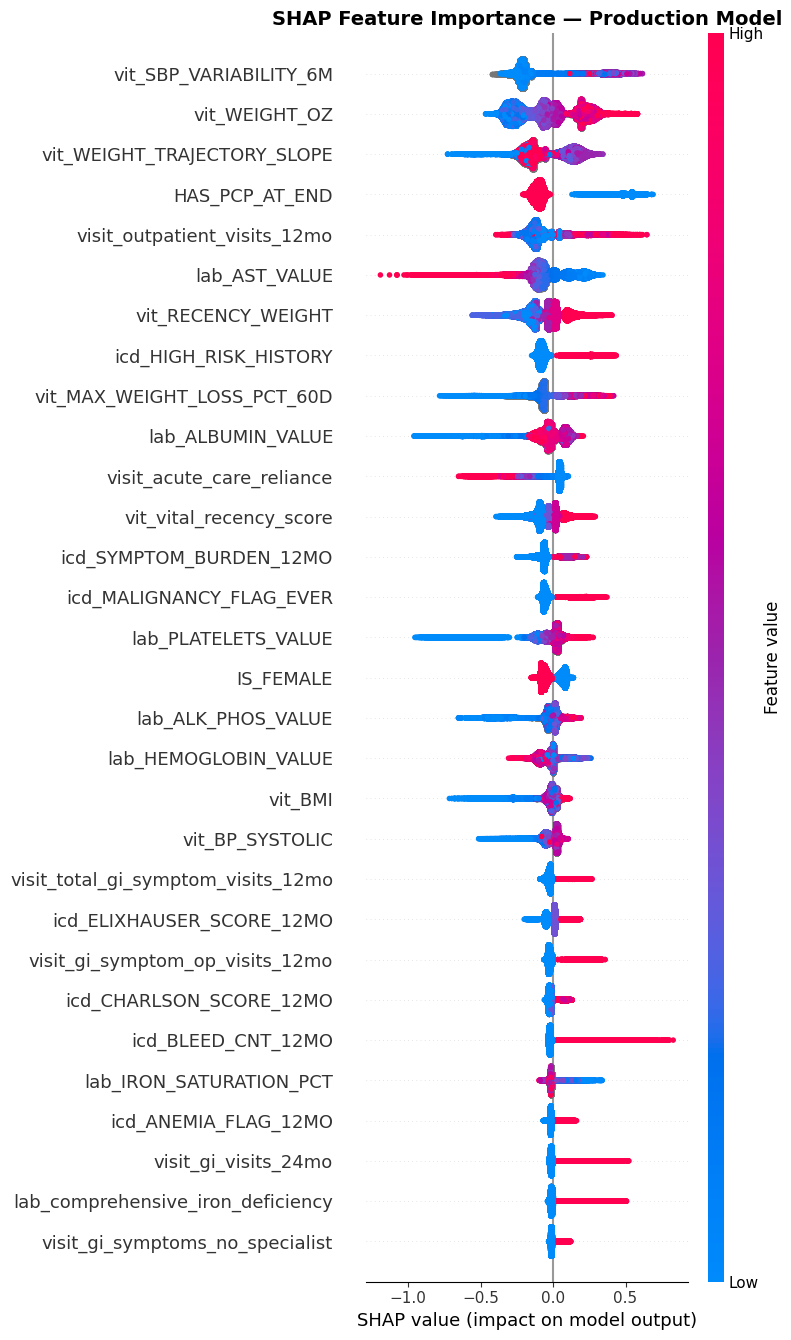

  [19:08:42]   Plot saved to feature_selection_outputs/mercy_med_adverse_phase5_shap_summary.png

COMPLETE PIPELINE SUMMARY

  Phase 1 (Clustering):     167 → 139 features
  Phase 2 (SHAP Winnowing): 139 → 30 features (26 iterations)
  Phase 3 (CV Stability):   5-fold cross-validation stability analysis
  Phase 4 (Parsimony):      Selected iter 26 → 30 features
  Phase 5 (Production):     Retrained with production params

  Final Features:  30
  EPV:             73
  Val AUPRC:       0.0523
  Test AUPRC:      0.0460
  Lift @ Top 1%:   21.9x (test)

  Output table:    dev.clncl_ds.herald_med_averse_final_features
  Model file:      feature_selection_outputs/mercy_med_adverse_phase5_production_model.json



In [0]:
# ============================================================================
# Step 5.5: SHAP Feature Importance Analysis
# ============================================================================
# Compute SHAP values on the validation set to understand feature
# contributions in the production model. This serves two purposes:
#   1. Verify that the model is using features as expected (sanity check)
#   2. Provide interpretable feature rankings for clinical documentation
#
# We use the validation set (not training) to avoid inflated importance
# from memorized patterns.
# ============================================================================

print_progress("")
print_progress("Step 5.5: Computing SHAP importance on validation set...")
shap_start = time.time()

# TreeExplainer is exact for tree-based models (no approximation needed)
explainer = shap.TreeExplainer(prod_model)
shap_values = explainer.shap_values(X_val)

shap_time = time.time() - shap_start
print_progress(f"  ✓ SHAP computation complete in {shap_time:.1f}s")

# Compute mean absolute SHAP value per feature (standard importance measure)
mean_abs_shap = np.abs(shap_values).mean(axis=0)

# Build importance ranking
shap_importance = pd.DataFrame({
    'feature': final_phase4_features,
    'mean_abs_shap': mean_abs_shap,
}).sort_values('mean_abs_shap', ascending=False).reset_index(drop=True)

# Add rank and cumulative importance
shap_importance['rank'] = range(1, len(shap_importance) + 1)
total_importance = shap_importance['mean_abs_shap'].sum()
shap_importance['pct_of_total'] = (
    shap_importance['mean_abs_shap'] / total_importance * 100
)
shap_importance['cumulative_pct'] = shap_importance['pct_of_total'].cumsum()

# Display the ranking
print()
print("=" * 70)
print("SHAP FEATURE IMPORTANCE (Production Model, Validation Set)")
print("=" * 70)
print(f"{'Rank':<5} {'Feature':<45} {'Mean |SHAP|':>11} {'% Total':>8} {'Cum %':>6}")
print("-" * 75)

for _, row in shap_importance.iterrows():
    print(f"{int(row['rank']):<5} {row['feature']:<45} "
          f"{row['mean_abs_shap']:>11.6f} "
          f"{row['pct_of_total']:>7.1f}% "
          f"{row['cumulative_pct']:>5.1f}%")

# Save SHAP importance
shap_path = os.path.join(OUTPUT_DIR, "mercy_med_adverse_phase5_shap_importance.csv")
shap_importance.to_csv(shap_path, index=False)
print_progress(f"  SHAP importance saved to {shap_path}")

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# SHAP summary plot (beeswarm)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Visual summary of how each feature pushes predictions up or down.
# Red = high feature value, blue = low feature value.
# Features sorted by importance (most important at top).
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

print_progress("Generating SHAP summary plot...")

fig, ax = plt.subplots(figsize=(12, max(6, len(final_phase4_features) * 0.35)))
shap.summary_plot(
    shap_values, X_val,
    feature_names=final_phase4_features,
    show=False,
    max_display=len(final_phase4_features),  # Show all features
)
plt.title("SHAP Feature Importance — Production Model", fontsize=14, fontweight='bold')
plt.tight_layout()

shap_plot_path = os.path.join(OUTPUT_DIR, "mercy_med_adverse_phase5_shap_summary.png")
plt.savefig(shap_plot_path, dpi=150, bbox_inches='tight')
plt.show()
print_progress(f"  Plot saved to {shap_plot_path}")

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Final pipeline summary
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

print()
print("=" * 70)
print("COMPLETE PIPELINE SUMMARY")
print("=" * 70)
print(f"""
  Phase 1 (Clustering):     167 → {features_by_iteration['phase1_clustered']['n_features']} features
  Phase 2 (SHAP Winnowing): {features_by_iteration['phase1_clustered']['n_features']} → {features_by_iteration[f'phase2_iter{phase2_df["iteration"].max()}_output']['n_features']} features ({phase2_df['iteration'].max()} iterations)
  Phase 3 (CV Stability):   5-fold cross-validation stability analysis
  Phase 4 (Parsimony):      Selected iter {selected_iteration} → {n_final} features
  Phase 5 (Production):     Retrained with production params

  Final Features:  {n_final}
  EPV:             {epv:.0f}
  Val AUPRC:       {val_metrics['auprc']:.4f}
  Test AUPRC:      {test_metrics['auprc']:.4f}
  Lift @ Top 1%:   {test_metrics['lift_1pct']:.1f}x (test)

  Output table:    {PHASE4_OUTPUT_TABLE}
  Model file:      {prod_model_path}
""")
print("=" * 70)

### Phase 5 Conclusion (Med-Averse Variant)

The production model was trained on the Phase 4 feature set with relaxed hyperparameters
suitable for a final model (max_depth=4, gamma=1.0). Key outputs:

- **Performance metrics** on train/val/test splits (AUPRC, AUROC, Brier, Lift)
- **SHAP feature importance** ranking with beeswarm visualization
- **Production model** saved for downstream calibration and deployment
- **Feature list table** saved to Spark for pipeline integration

**Note:** This model used med-averse tiebreaking during Phase 2 SHAP winnowing — medication features were preferentially removed when tied with non-medication alternatives. Any medication features remaining in the final set survived on merit (clearly stronger signal than non-medication alternatives).

**Next steps:**
1. Isotonic calibration (predict_proba → calibrated 0-100 risk score)
2. Threshold selection for clinical decision rules
3. External validation on held-out time period